# Time-Series Forecasting: Prédictions récursives des valeurs du SP500 sur 100 jours

Attention : l'exécution de ce notebook prend plusieurs heures même avec un bon processeur et carte graphique, merci de vous armer de patience si vous souhaitez exécuter ce notebook, environ 80GB de RAM/VRAM sont également recommandé. L'utilisation de carte graphique récente dédiée (voir spécialisé type Nvidia A100) est fortement recommandé

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, Add, Conv1D, MultiHeadAttention, Dropout, Bidirectional
from tensorflow.keras.models import Model 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from itertools import product
from keras.callbacks import EarlyStopping
import torch
from torch.optim import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import acf, pacf
from math import sqrt
from skopt import gp_minimize
from skopt.space import Integer
import optuna
import plotly
from tensorflow.keras.layers import Attention
from sklearn.model_selection import TimeSeriesSplit
from keras.regularizers import l1, l2, l1_l2
from datetime import datetime, timedelta
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from scipy.ndimage import gaussian_filter1d
from scipy.stats import kurtosis, skew
from keras import backend as K
from sklearn.metrics import confusion_matrix

In [2]:
print(tf.config.experimental.list_physical_devices('GPU'))
print(torch.cuda.is_available())
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Utiliser le premier GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [3]:
# Calculer la date d'hier
yesterday = datetime.now() - timedelta(1)
yesterday_str = yesterday.strftime('%Y-%m-%d')
# import the data
GSPC_data= yf.download('^GSPC',start='2001-06-25',end=yesterday_str)
VIX_data = yf.download('^VIX', start='2001-06-25', end=yesterday_str)
CL_DF_data = yf.download('CL=F', start='2001-06-25', end=yesterday_str)
GC_F_data = yf.download('GC=F', start='2001-06-25', end=yesterday_str)
EURUSD_X_data = yf.download('EURUSD=X', start='2001-06-25', end=yesterday_str)
GBPUSD_X_data = yf.download('GBPUSD=X', start='2001-06-25', end=yesterday_str)
JPY_X_data = yf.download('JPY=X', start='2001-06-25', end=yesterday_str)
RUB_X_data = yf.download('RUB=X', start='2001-06-25', end=yesterday_str)
NG_F_data = yf.download('NG=F', start='2001-06-25', end=yesterday_str)
TNX_data = yf.download('^TNX', start='2001-06-25', end=yesterday_str)
FVX_data = yf.download('^FVX', start='2001-06-25', end=yesterday_str)
FCHI_data = yf.download('^FCHI', start='2001-06-25', end=yesterday_str)
DJI_data = yf.download('^DJI', start='2001-06-25', end=yesterday_str)
JPM_data = yf.download('JPM', start='2001-06-25', end=yesterday_str)
CNY_X_data = yf.download('CNY=X', start='2001-06-25', end=yesterday_str)
SZ_data = yf.download('399001.SZ', start='2001-06-25', end=yesterday_str)
SS_data = yf.download('000001.SS', start='2001-06-25', end=yesterday_str)
MXX_data = yf.download('^MXX', start='2001-06-25', end=yesterday_str)
BVSP_data = yf.download('^BVSP', start='2001-06-25', end=yesterday_str)
N225_data = yf.download('^N225', start='2001-06-25', end=yesterday_str)
HSI_data = yf.download('^HSI', start='2001-06-25', end=yesterday_str)
STI_data = yf.download('^STI', start='2001-06-25', end=yesterday_str)
BSESN_data = yf.download('^BSESN', start='2001-06-25', end=yesterday_str)
TSM_data = yf.download('TSM', start='2001-06-25', end=yesterday_str) 
ORAPA_data = yf.download('ORA.PA', start='2001-06-25', end=yesterday_str)
VZ_data = yf.download('VZ', start='2001-06-25', end=yesterday_str)
VODL_data = yf.download('VOD.L', start='2001-06-25', end=yesterday_str) 
ADBE_data = yf.download('ADBE', start='2001-06-25', end=yesterday_str)
AAPL_data = yf.download('AAPL', start='2001-06-25', end=yesterday_str)
MSFT_data = yf.download('MSFT', start='2001-06-25', end=yesterday_str)
ORCL_data = yf.download('ORCL', start='2001-06-25', end=yesterday_str)
IBM_data = yf.download('IBM', start='2001-06-25', end=yesterday_str)
INTC_data = yf.download('INTC', start='2001-06-25', end=yesterday_str)
QCOM_data = yf.download('QCOM', start='2001-06-25', end=yesterday_str)
NVDA_data = yf.download('NVDA', start='2001-06-25', end=yesterday_str)
AMZN_data = yf.download('AMZN', start='2001-06-25', end=yesterday_str)
TXN_data = yf.download('TXN', start='2001-06-25', end=yesterday_str)
CVX_data = yf.download('CVX', start='2001-06-25', end=yesterday_str) 
AIPA_data = yf.download('AI.PA', start='2001-06-25', end=yesterday_str)

[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed


C:\Python310\lib\site-packages\yfinance\utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [4]:
GSPC_data.shape

(5665, 6)

Text(0.5, 1.0, 'Closing price History')

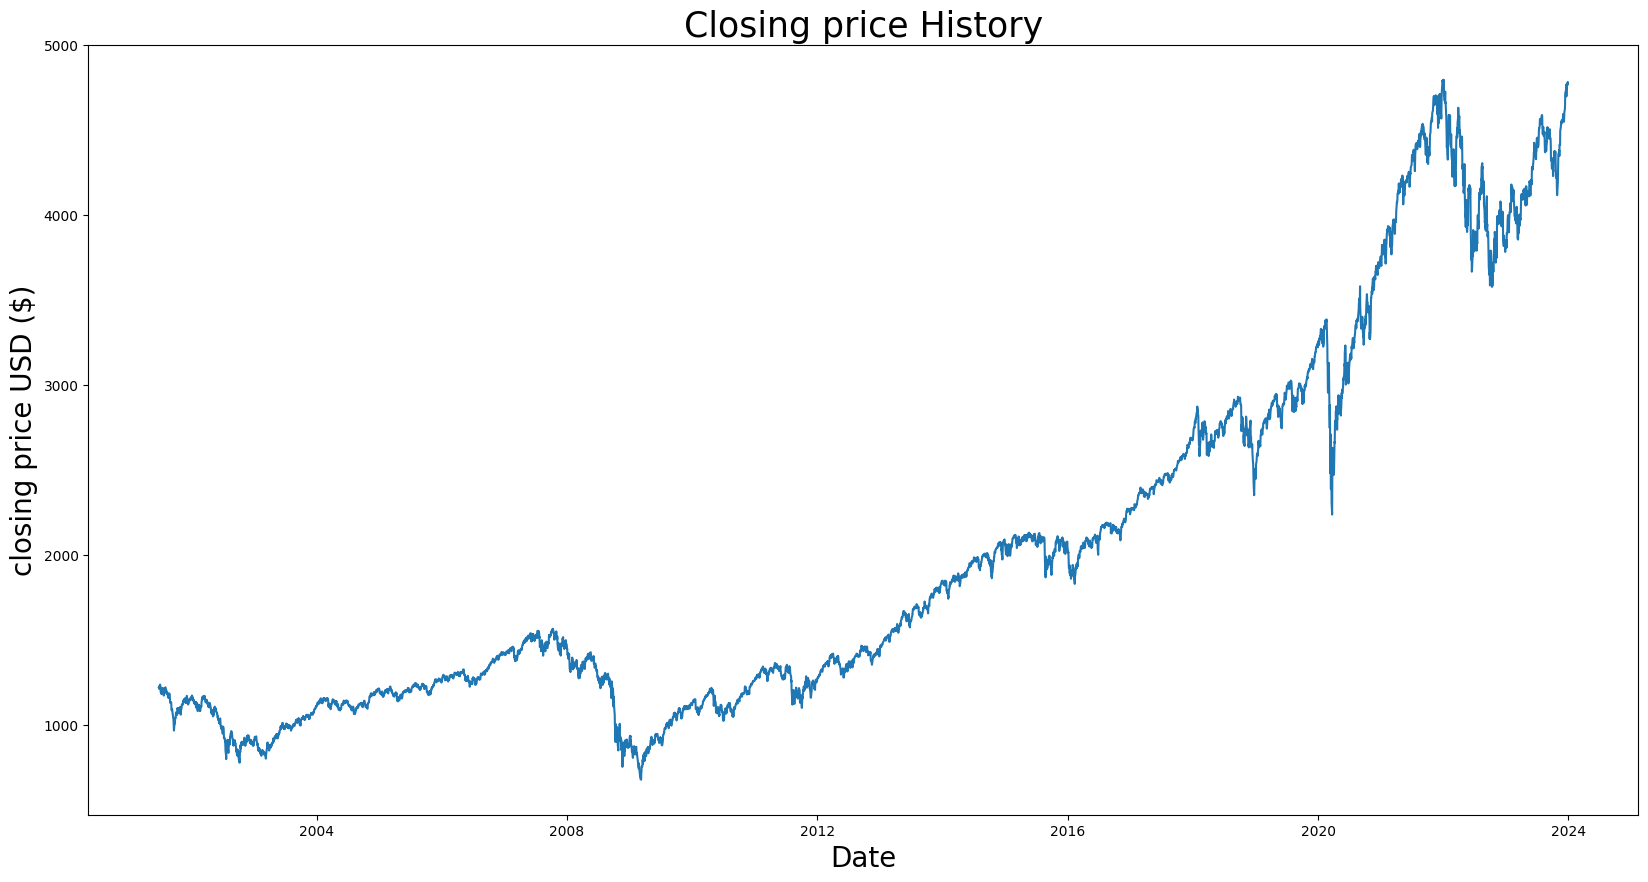

In [5]:
#lets look at the stock closing price of history
plt.figure(figsize=(20,10))
sns.lineplot(x= GSPC_data.index,y=GSPC_data['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('closing price USD ($)',fontsize=20)
plt.title('Closing price History',fontsize=25)

In [6]:
# Liste de vos DataFrames et leurs noms
dataframes = [GSPC_data, VIX_data, CL_DF_data, GC_F_data, EURUSD_X_data, GBPUSD_X_data, JPY_X_data, RUB_X_data, NG_F_data, TNX_data, FVX_data, FCHI_data, DJI_data, CNY_X_data, SZ_data, SS_data, MXX_data, BVSP_data, N225_data, HSI_data, STI_data, BSESN_data, TSM_data, ORAPA_data, VZ_data, VODL_data, ADBE_data, AAPL_data, MSFT_data, ORCL_data, IBM_data, INTC_data, QCOM_data, NVDA_data, AMZN_data, TXN_data, CVX_data, AIPA_data]
names = ['GSPC', 'VIX', 'CL_DF', 'GC_F', 'EURUSD_X', 'GBPUSD_X', 'JPY_X', 'RUB_X', 'NG_F', 'TNX', 'FVX', 'FCHI', 'DJI', 'CNY_X', 'SZ', 'SS', 'MXX', 'BVSP', 'N225', 'HSI', 'STI', 'BSESN', 'TSM', 'ORAPA', 'VZ', 'VODL', 'ADBE', 'AAPL', 'MSFT', 'ORCL', 'IBM', 'INTC', 'QCOM', 'NVDA', 'AMZN', 'TXN', 'CVX', 'AIPA']

# Initialiser un DataFrame vide
combined_data = pd.DataFrame()

# Parcourir chaque DataFrame et ajouter ses colonnes au DataFrame combiné
for df, name in zip(dataframes, names):
    # Sélectionnez seulement les colonnes qui vous intéressent (Open, Close, Min, Max)
    selected_columns = df[['Open', 'Close']]
    
    # Renommez les colonnes pour inclure le nom de l'indice
    selected_columns.columns = pd.MultiIndex.from_product([[name], ['Open', 'Close']])
    
    # Concaténez les colonnes sélectionnées au DataFrame combiné
    if combined_data.empty:
        combined_data = selected_columns
    else:
        combined_data = pd.concat([combined_data, selected_columns], axis=1)

combined_data.dropna(inplace=True)
# Affichez les premières lignes du DataFrame combiné
print(combined_data.shape)

(3721, 76)


### Carte de chaleur de correlation entre les features du modèle:

In [7]:
# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

### Sélection des features

In [8]:
# Sélectionner les caractéristiques avec une forte corrélation
target = ('GSPC', 'Close')
correlation_threshold = 0.8

# Trouver les caractéristiques fortement corrélées
highly_correlated_features = [idx for idx, corr in correlation_matrix[target].items() if abs(corr) > correlation_threshold]

print(f"Selected indices: {highly_correlated_features}")

Selected indices: [('GSPC', 'Open'), ('GSPC', 'Close'), ('RUB_X', 'Open'), ('RUB_X', 'Close'), ('FCHI', 'Open'), ('FCHI', 'Close'), ('DJI', 'Open'), ('DJI', 'Close'), ('BVSP', 'Open'), ('BVSP', 'Close'), ('N225', 'Open'), ('N225', 'Close'), ('BSESN', 'Open'), ('BSESN', 'Close'), ('TSM', 'Open'), ('TSM', 'Close'), ('ADBE', 'Open'), ('ADBE', 'Close'), ('AAPL', 'Open'), ('AAPL', 'Close'), ('MSFT', 'Open'), ('MSFT', 'Close'), ('ORCL', 'Open'), ('ORCL', 'Close'), ('QCOM', 'Open'), ('QCOM', 'Close'), ('NVDA', 'Open'), ('NVDA', 'Close'), ('AMZN', 'Open'), ('AMZN', 'Close'), ('TXN', 'Open'), ('TXN', 'Close'), ('AIPA', 'Open'), ('AIPA', 'Close')]


### Gestion de la Multicollinéarité

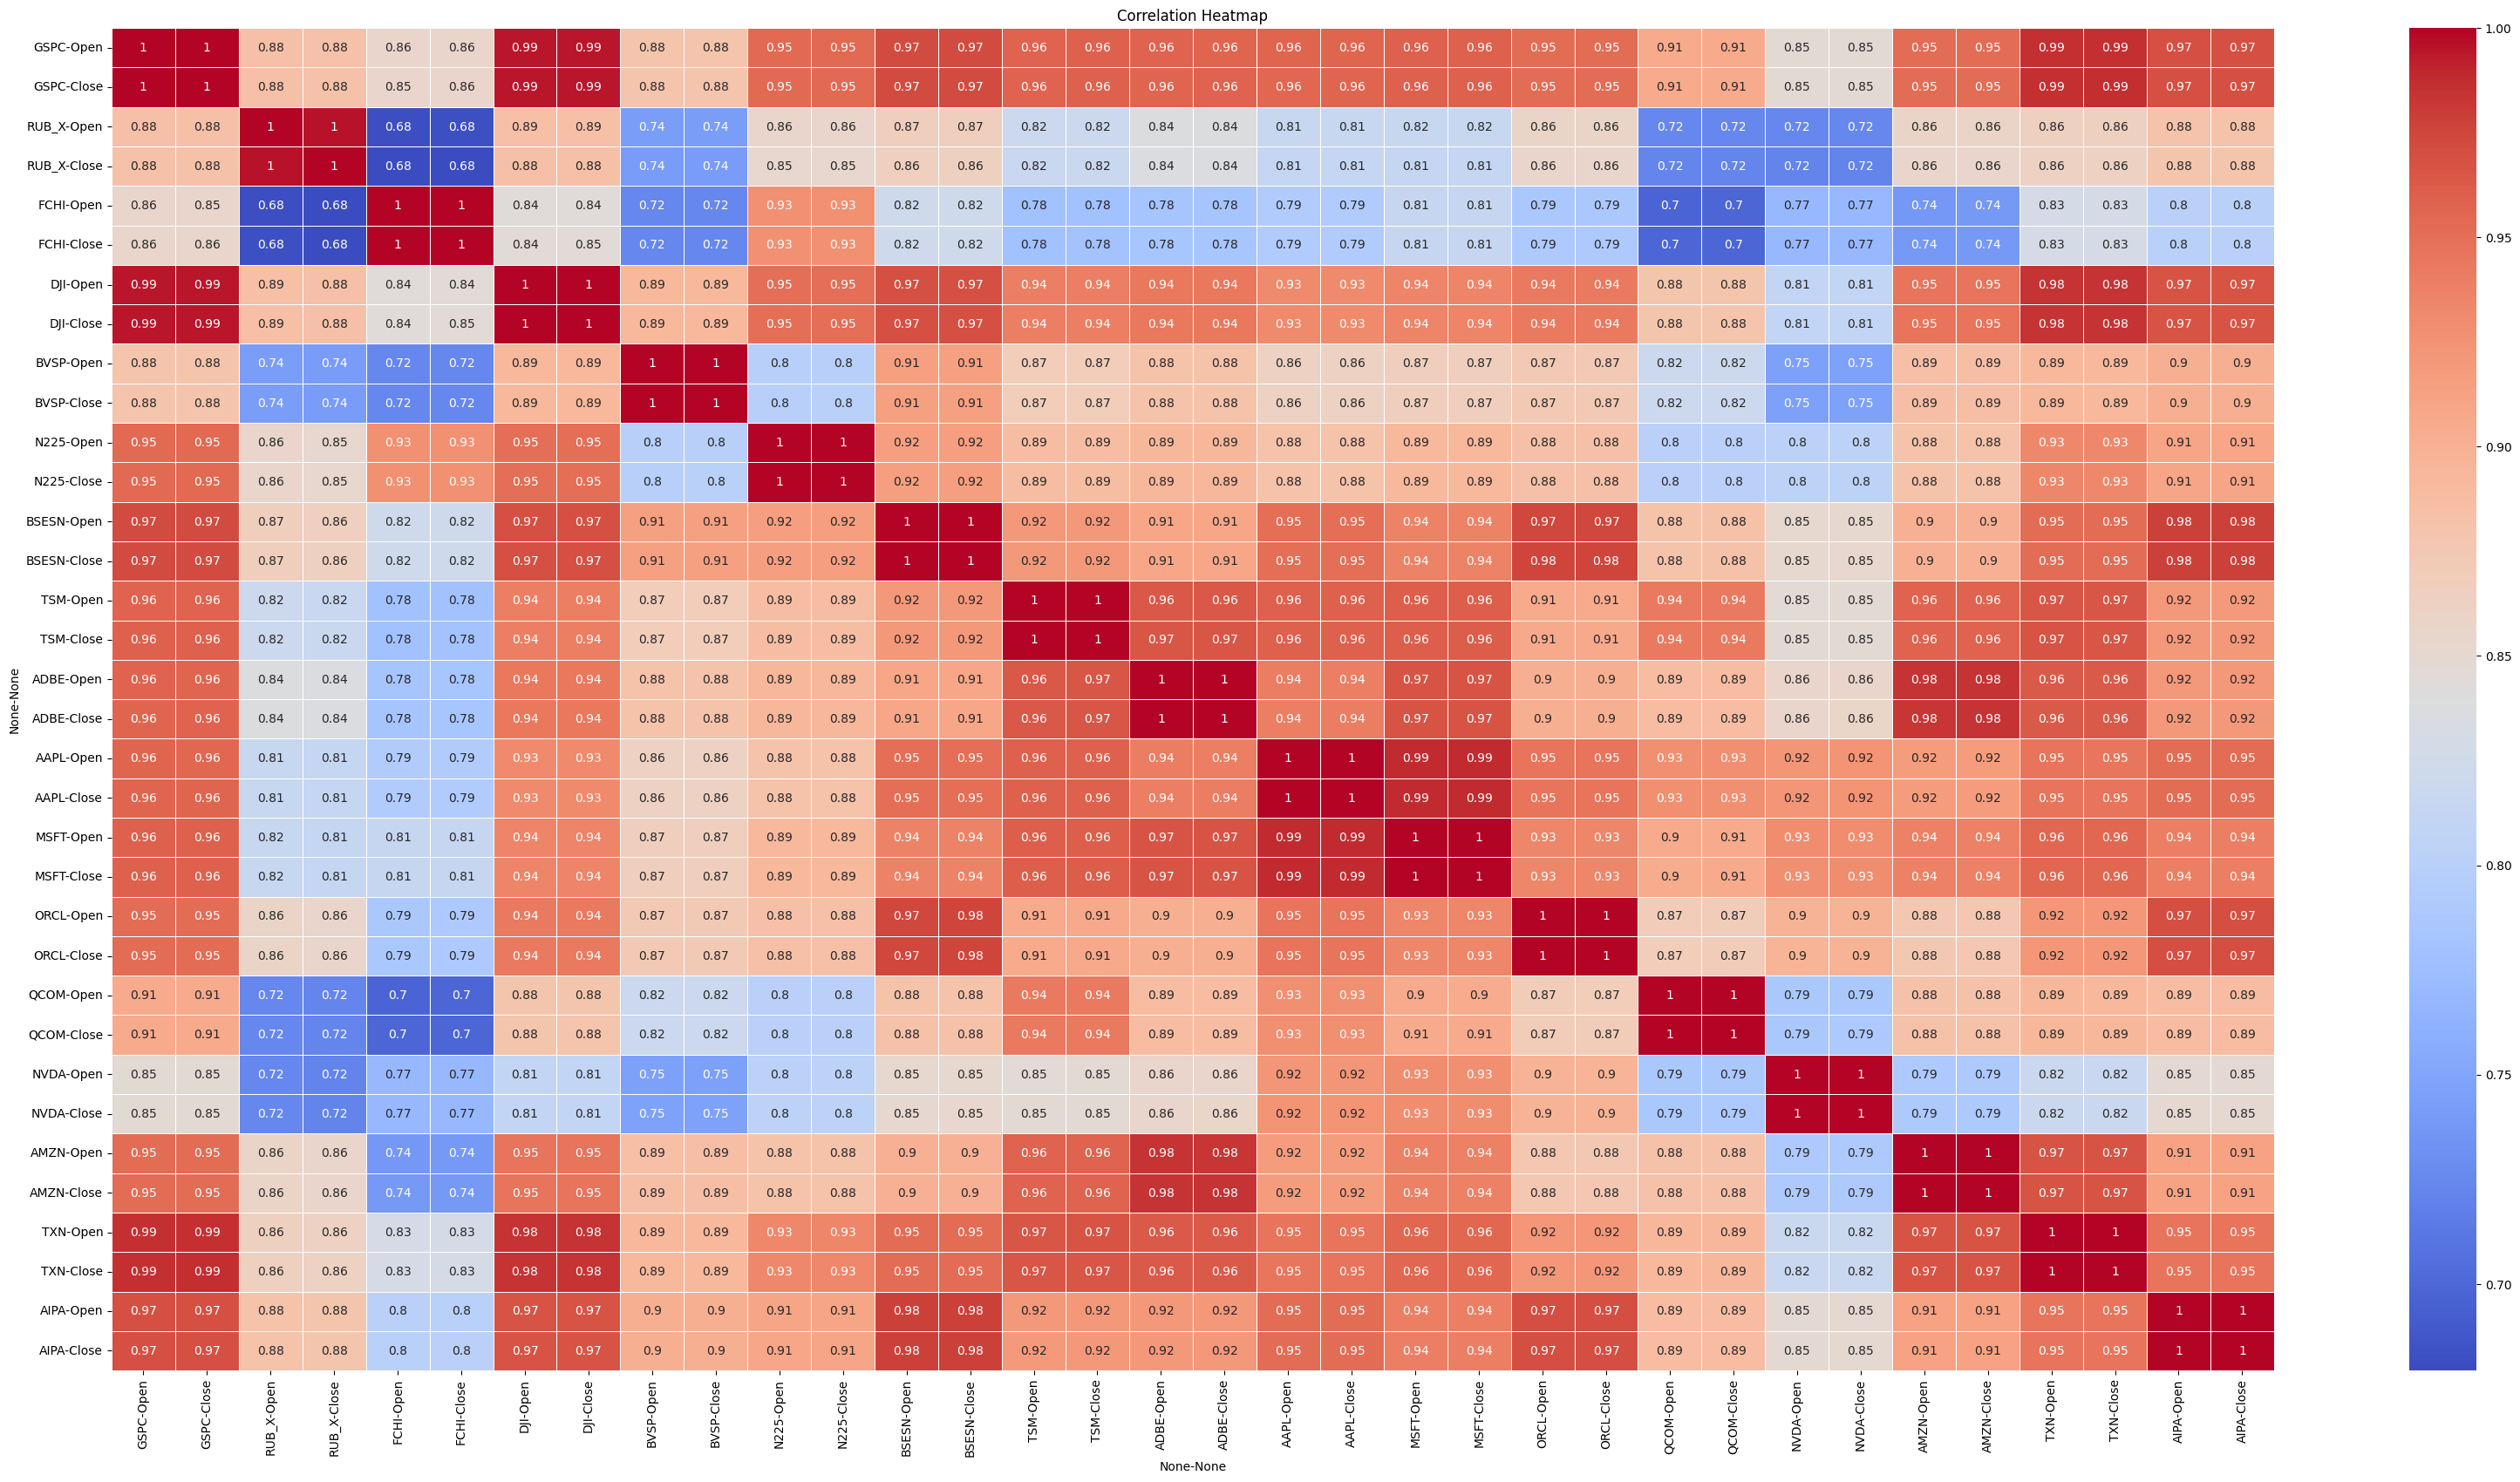

In [9]:
# Afficher la heatmap
selected_correlation_matrix = combined_data[highly_correlated_features].corr()

plt.figure(figsize=(40, 20))
sns.heatmap(selected_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [10]:
# Calculate VIF
def calculate_vif(dataframe, threshold=4.0):
    vif = pd.DataFrame()
    vif["Variable"] = [str(col) for col in dataframe.columns]
    vif["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    
    while vif["VIF"].max() > threshold:
        remove = vif.sort_values("VIF", ascending=False).iloc[0]
        removed_var = dataframe.columns[int(remove.name)]
        dataframe = dataframe.drop(removed_var, axis=1)
        vif = pd.DataFrame()
        vif["Variable"] = [str(col) for col in dataframe.columns]
        vif["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]

    return dataframe

### Sélection des features définitives:

In [11]:
#highly_correlated_features.remove(target)
filtred_df = combined_data[highly_correlated_features].copy()
last_two_years_data = combined_data.last('2Y')

close_values_last_two_years = last_two_years_data.xs('Close', level=1, axis=1)
reduced_df = calculate_vif(close_values_last_two_years)

# Conserver seulement les indices qui ne sont pas colinéaires
valid_indices = reduced_df.columns.tolist()

# Créer un nouveau DataFrame contenant toutes les variables pour ces indices
final_df = combined_data.loc[:, pd.IndexSlice[valid_indices, :]]
print(final_df.shape)

C:\Users\MATTMSI\AppData\Local\Temp\ipykernel_7224\1392837044.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_two_years_data = combined_data.last('2Y')
C:\Users\MATTMSI\AppData\Local\Temp\ipykernel_7224\1392837044.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  last_two_years_data = combined_data.last('2Y')


(3721, 4)


### Normalisation des données

In [12]:
# Initialisez un dictionnaire pour stocker les scalers
scalers_dict = {}

# Créez un DataFrame vide pour stocker les données mises à l'échelle
scaled_data_df = pd.DataFrame(index=final_df.index)

# Itérer sur le premier niveau de l'index multi-niveaux (noms des indices)
for first_level in final_df.columns.levels[0]:
    # Itérer sur le second niveau de l'index multi-niveaux (Open, Close, High, Low)
    for second_level in final_df.columns.levels[1]:
        feature = (first_level, second_level)
        
        if feature in final_df.columns:
            feature_scaler = RobustScaler()
            scaled_feature = feature_scaler.fit_transform(final_df[feature].values.reshape(-1, 1))
            scaled_data_df[feature] = scaled_feature.flatten()  # Convertir les données 2D en 1D
            
            # Stocker le scaler pour chaque combinaison d'indice et de mesure
            scalers_dict[feature] = feature_scaler

print(scaled_data_df.tail())

            (NG_F, Close)  (NG_F, Open)  (NVDA, Close)  (NVDA, Open)
Date                                                                
2023-12-20      -0.449779     -0.417403       9.558380      9.852528
2023-12-21      -0.407218     -0.461591       9.735028      9.683186
2023-12-22      -0.394280     -0.408226       9.702873      9.760233
2023-12-27      -0.391216     -0.409585       9.820840      9.823635
2023-12-28      -0.412326     -0.452074       9.841941      9.850120


In [13]:
# Split into train and test:
# Définissez la taille de l'ensemble d'entraînement
train_size = int(len(scaled_data_df)) - 250
test_size = 250

# Séparez les données
train_data = scaled_data_df.iloc[:train_size]
test_data = scaled_data_df.iloc[train_size:]
print(train_data.shape)
print(test_data.shape)

(3471, 4)
(250, 4)


In [14]:
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

### Création d'une métrique personalisée pour la prédiction récursive 

In [15]:
def weighted_rmse(y_true, y_pred, total_observations):
    weights = np.arange(total_observations, 0, -1) / total_observations
    weighted_square_errors = weights * ((y_pred - y_true) ** 2)
    weighted_rmse = sqrt(np.mean(weighted_square_errors))
    return weighted_rmse
    
    weighted_square_errors = weights * ((y_pred - y_true) ** 2)
    weighted_rmse = sqrt(np.mean(weighted_square_errors))
    return weighted_rmse

# Recherche de la meilleure architecture pour les modèles neuronaux

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
best_params_per_feature = {}
top_n_trials_per_feature = {}

# Function to create sequences for multi-output prediction

def create_single_output_sequences(data, index_name, look_back=1):
    X, y = [], []
    feature_columns = ['Close']
    for i in range(look_back, len(data)):
        sequence_data = data.loc[data.index[i-look_back:i], [(index_name, col) for col in feature_columns]].values
        X.append(sequence_data)
        y.append(data.loc[data.index[i], [(index_name, 'Close')]].values[0])
    return np.array(X), np.array(y)

def generate_recursive_predictions(model, X_val, n_steps=10):
    # Supposons que X_val soit de forme (nombre_d'exemples, look_back, nombre_de_features)
    recursive_predictions = []
    input_sequence = X_val[0].reshape(1, X_val.shape[1], X_val.shape[2])  # Prendre la première séquence

    for i in range(n_steps):
        # Faire une prédiction à partir de la séquence d'entrée
        prediction = model.predict(input_sequence, verbose=0)
        recursive_predictions.append(prediction[0, 0])

        # Mettre à jour la séquence d'entrée pour inclure la nouvelle prédiction
        new_input_sequence = np.append(input_sequence[0, 1:, :], prediction)
        input_sequence = new_input_sequence.reshape(1, X_val.shape[1], X_val.shape[2])

    return np.array(recursive_predictions)


def create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, input_shape, use_conv1d , conv1d_filters ,conv1d_kernel_size ,use_residual_connection, attention_layer, l1_reg, l2_reg):
    inputs = Input(shape=input_shape)
    x = inputs
    if use_conv1d:
        x = Conv1D(conv1d_filters, kernel_size=conv1d_kernel_size, activation='relu')(x)
    if layer_type[0] == "GRU":
        x = Bidirectional(GRU(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    elif layer_type[0] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    x = Dropout(dropout_per_layer[0])(x)
    for i in range(1, num_layers):
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x_res = x
        if layer_type[i] == "GRU":
            x = Bidirectional(GRU(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        elif layer_type[i] == "LSTM":
            x = Bidirectional(LSTM(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        x = Dropout(dropout_per_layer[i])(x)
        if attention_layer:
            x = Attention(use_scale=True)([x, x])
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x = Add()([x, x_res])
    if layer_type[num_layers-1] == "GRU":
        x = Bidirectional(GRU(units_per_layer[num_layers-1]))(x)
    elif layer_type[num_layers-1] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[num_layers-1]))(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

for index_name in final_df.columns.get_level_values(0).unique():  # Parcourir chaque indice

    # Définition de l'objectif
    def objective(trial):

        # Espace de recherche
        ###############################################################################################
        look_back = trial.suggest_int('look_back', int(test_size/4), int(test_size/2) - 1)
        num_layers = trial.suggest_int('num_layers', 5, 8)
        layer_type = [trial.suggest_categorical(f'layer_type_{i}', ['LSTM', 'GRU']) for i in range(num_layers)]
        units_per_layer = [trial.suggest_int(f'units_power_{i}', 7, 9) for i in range(num_layers)]
        units_per_layer = [2 ** power for power in units_per_layer]
        dropout_per_layer = [trial.suggest_float(f'dropout_{i}', 0.1, 0.3) for i in range(num_layers)]
        use_residual_connection = trial.suggest_categorical('use_residual_connection', [True, False])
        attention_layer = trial.suggest_categorical('use_attention_layer', [True, False])
        use_conv1d = trial.suggest_categorical('use_conv1d', [False, True])
        if use_conv1d:
            conv1d_filters = trial.suggest_int('conv1d_filters', 5, 7)
            conv1d_filters = 2 ** conv1d_filters
            conv1d_kernel_size = trial.suggest_int('conv1d_kernel_size', 3, 7)
        l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-1, log=True)
        l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-1, log=True)
        ################################################################################################

        # Créez des séquences en utilisant look_back
        X_train, y_train = create_single_output_sequences(train_data, index_name , look_back)
        X_test, y_test = create_single_output_sequences(test_data, index_name ,look_back)

        n_splits = 5  # Nombre de splits
        tscv = TimeSeriesSplit(n_splits=n_splits)

        val_loss_list = []  # Liste pour stocker la val_loss de chaque split
        mda_list = []  # Liste pour stocker MDA de chaque split
        train_loss_list = []  # Liste pour stocker la loss de chaque split

        for train_index, val_index in tscv.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            if use_conv1d:
                model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), 1), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)
            else:
                conv1d_filters = 36
                conv1d_kernel_size = 5
                model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), 1), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)

            history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=10, batch_size=64, verbose=0, callbacks=[early_stopping])

            last_val_loss = history.history['val_loss'][-1]
            last_train_loss = history.history['loss'][-1]
            
            # Calcul de MDA
            y_true_direction = np.sign(np.diff(y_val_fold.reshape(-1)))  # vrai direction
            y_pred_direction = np.sign(np.diff(model.predict(X_val_fold, verbose=0).reshape(-1)))  # prédiction de direction
            mda = np.mean(y_true_direction == y_pred_direction)
            
            val_loss_list.append(last_val_loss)
            train_loss_list.append(last_train_loss)
            mda_list.append(mda)
        
        mean_val_loss = np.mean(val_loss_list)
        mean_train_loss = np.mean(train_loss_list)
        mean_mda = np.mean(mda_list)
        
        
        # Calcul des malus
        loss_difference_malus = abs(mean_val_loss - mean_train_loss) * 1
        recursive_predictions = generate_recursive_predictions(model, X_val_fold, len(X_val_fold))
        std_value = np.std(recursive_predictions)  # Calcul de l'écart-type des prédictions récursives
        if std_value == 0:
            std_malus = 3  # Si l'écart-type est de 0, pénalité maximale
        else:
            std_malus = 1 - std_value

        # Calcul du score final avec les malus
        final_score = (1 - mean_mda) + loss_difference_malus + std_malus

        print("mda: " + str(mean_mda))
        print("loss diff: " + str(loss_difference_malus))
        print("std: " + str(std_malus))

        return final_score

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=35)
    
    best_params_per_feature[index_name] = study.best_params

    top_n_trials = sorted(study.trials, key=lambda trial: trial.value)[:5]

    # Stockez les meilleurs hyperparamètres
    top_n_params = [trial.params for trial in top_n_trials]

    # Stockez ces meilleurs paramètres dans le dictionnaire
    top_n_trials_per_feature[index_name] = top_n_params

    # Affichage des résultats
    print(f'Number of finished trials for {index_name}: ', len(study.trials))
    print('Best 5 trials:')
    for i, trial in enumerate(top_n_trials):
        print(f'Rank {i+1} - Value: {trial.value}, Params: {trial.params}')

[I 2024-01-03 19:26:11,152] A new study created in memory with name: no-name-cea10d11-8240-4a72-88cd-639df0caf0a9
[I 2024-01-03 19:32:12,411] Trial 0 finished with value: 1.1752559991456448 and parameters: {'look_back': 120, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'dropout_0': 0.16473710966029131, 'dropout_1': 0.2153386385466759, 'dropout_2': 0.2712391000093387, 'dropout_3': 0.21282684406851, 'dropout_4': 0.11601894598664307, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 5.64721197449839e-05, 'l2_reg': 1.9106773002191902e-05}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.48150807899461395
loss diff: 0.05491064786911015
std: 0.6018534302711487


[I 2024-01-03 19:39:00,465] Trial 1 finished with value: 3.09429131806853 and parameters: {'look_back': 95, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.23313732202554535, 'dropout_1': 0.266029948332558, 'dropout_2': 0.2297438539668657, 'dropout_3': 0.25861290361793443, 'dropout_4': 0.22829475653656264, 'dropout_5': 0.20675521430108873, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 7, 'l1_reg': 0.008097501578293429, 'l2_reg': 9.158187609898305e-05}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.32620320855614976
loss diff: 1.420494556427002
std: 0.9999999701976776


[I 2024-01-03 19:46:58,543] Trial 2 finished with value: 2.20776405807181 and parameters: {'look_back': 83, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.1941986672915694, 'dropout_1': 0.21823192209379222, 'dropout_2': 0.16535353025041502, 'dropout_3': 0.26862763563591774, 'dropout_4': 0.2149161276087807, 'dropout_5': 0.17344619695018088, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 4, 'l1_reg': 0.00025386633384274316, 'l2_reg': 0.003739220177256883}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.49200710479573717
loss diff: 0.8367650032043468
std: 0.8630061596632004


[I 2024-01-03 19:52:18,198] Trial 3 finished with value: 4.428723884177419 and parameters: {'look_back': 73, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'dropout_0': 0.2432845846838138, 'dropout_1': 0.17495763806765496, 'dropout_2': 0.11710461286741763, 'dropout_3': 0.2836001960937937, 'dropout_4': 0.2979456131642742, 'dropout_5': 0.2005885353856488, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 0.014857647454697767, 'l2_reg': 2.4994662973987515e-05}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.4527433628318584
loss diff: 0.8814672470092777
std: 3


[I 2024-01-03 19:58:13,384] Trial 4 finished with value: 1.6757166758282591 and parameters: {'look_back': 97, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'dropout_0': 0.16580415536705778, 'dropout_1': 0.1794613380871028, 'dropout_2': 0.18820912970091913, 'dropout_3': 0.25881533237260446, 'dropout_4': 0.1039563039166278, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.002266035199991839, 'l2_reg': 6.388533753713365e-05}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.4830659536541889
loss diff: 0.16233150959014897
std: 0.9964511198922992


[I 2024-01-03 20:08:55,062] Trial 5 finished with value: 5.748989250062827 and parameters: {'look_back': 123, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 7, 'units_power_5': 9, 'units_power_6': 9, 'units_power_7': 8, 'dropout_0': 0.2551028894279651, 'dropout_1': 0.26829793913384514, 'dropout_2': 0.2781034788178942, 'dropout_3': 0.11197124793567265, 'dropout_4': 0.23941278980816308, 'dropout_5': 0.25547692105169306, 'dropout_6': 0.19233866037158653, 'dropout_7': 0.29228078843551564, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.023387629533193437, 'l2_reg': 0.0034395700384904047}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.4007181328545781
loss diff: 4.149707412719728
std: 0.9999999701976776


[I 2024-01-03 20:14:29,157] Trial 6 finished with value: 3.991646594642574 and parameters: {'look_back': 72, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.24395239945225758, 'dropout_1': 0.19201904895930452, 'dropout_2': 0.2026518192342523, 'dropout_3': 0.2899820456193247, 'dropout_4': 0.28096822623176243, 'dropout_5': 0.19537640667993106, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.034361043987924354, 'l2_reg': 0.00042384063371065484}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.49486725663716813
loss diff: 2.4865139007568366
std: 0.9999999505229056


[I 2024-01-03 20:22:23,234] Trial 7 finished with value: 1.506564108218465 and parameters: {'look_back': 104, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.21596542946380856, 'dropout_1': 0.2254916931533936, 'dropout_2': 0.2916509713579545, 'dropout_3': 0.25271994930480457, 'dropout_4': 0.1427969798458332, 'dropout_5': 0.1252920218228491, 'dropout_6': 0.2863522245628555, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 7, 'l1_reg': 0.0001115138885766597, 'l2_reg': 0.00015537733485179546}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.4885714285714286
loss diff: 0.08915123939514125
std: 0.9059842973947525


[I 2024-01-03 20:31:12,280] Trial 8 finished with value: 2.1010695656174465 and parameters: {'look_back': 109, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.27391708491680844, 'dropout_1': 0.2856699077659123, 'dropout_2': 0.28865947922198737, 'dropout_3': 0.21298654949153023, 'dropout_4': 0.17761275925323297, 'dropout_5': 0.20825986689991616, 'dropout_6': 0.21318187777379194, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.003455087287703211, 'l2_reg': 0.005718061099837176}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.4708407871198569
loss diff: 0.5719103813171387
std: 0.9999999714201646


[I 2024-01-03 20:38:46,846] Trial 9 finished with value: 2.6039454487638825 and parameters: {'look_back': 99, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.2770214251025225, 'dropout_1': 0.1341566554965167, 'dropout_2': 0.1104817752698169, 'dropout_3': 0.23930728172198482, 'dropout_4': 0.19786836135916613, 'dropout_5': 0.2675322138082058, 'dropout_6': 0.27657489773298277, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 0.0037805302467156282, 'l2_reg': 0.04425230607511222}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.46096256684491976
loss diff: 1.0649080753326405
std: 0.9999999402761617


[I 2024-01-03 20:45:14,556] Trial 10 finished with value: 1.5135484530344687 and parameters: {'look_back': 119, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 7, 'dropout_0': 0.1028773501103495, 'dropout_1': 0.10865002398964634, 'dropout_2': 0.24630208650436283, 'dropout_3': 0.1551202253724724, 'dropout_4': 0.10884736723074913, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 1.808796871362979e-05, 'l2_reg': 1.4042529135024849e-05}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.4789946140035906
loss diff: 0.02937896847724908
std: 0.9631640985608101


[I 2024-01-03 20:54:35,445] Trial 11 finished with value: 1.5400306523342704 and parameters: {'look_back': 111, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.15035306986061553, 'dropout_1': 0.22599276524122758, 'dropout_2': 0.29563323220683185, 'dropout_3': 0.19286172295645737, 'dropout_4': 0.14163666910859413, 'dropout_5': 0.10272023318097143, 'dropout_6': 0.2911228366754361, 'dropout_7': 0.10245706037165327, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.00012596424851732106, 'l2_reg': 0.00027527084555650235}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.49051878354203937
loss diff: 0.04359328746795654
std: 0.9869561484083533


[I 2024-01-03 21:02:30,272] Trial 12 finished with value: 1.468397526088469 and parameters: {'look_back': 109, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.1888946785679771, 'dropout_1': 0.2211940734596777, 'dropout_2': 0.253647531757774, 'dropout_3': 0.20860904665729235, 'dropout_4': 0.14754668046503855, 'dropout_5': 0.12887155802025116, 'dropout_6': 0.10289062301800837, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 1.577117423209654e-05, 'l2_reg': 0.00011487221808748269}. Best is trial 0 with value: 1.1752559991456448.


mda: 0.47978533094812165
loss diff: 0.04350987672805795
std: 0.9046729803085327


[I 2024-01-03 21:09:41,247] Trial 13 finished with value: 0.5689472709932635 and parameters: {'look_back': 114, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.17302911256005366, 'dropout_1': 0.2496292095311106, 'dropout_2': 0.24703750463105384, 'dropout_3': 0.1922881093539858, 'dropout_4': 0.14883254084193454, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 1.482022563377456e-05, 'l2_reg': 2.823948223005783e-05}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.4838709677419355
loss diff: 0.033442676067352295
std: 0.01937556266784668


[I 2024-01-03 21:17:05,426] Trial 14 finished with value: 1.541243540605123 and parameters: {'look_back': 116, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.13421657922775576, 'dropout_1': 0.2495481154010304, 'dropout_2': 0.22064516602791262, 'dropout_3': 0.17333153515383487, 'dropout_4': 0.16385748602565, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 4.5846195416072356e-05, 'l2_reg': 1.1154716033102048e-05}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.48243727598566305
loss diff: 0.07816224098205571
std: 0.9455185756087303


[I 2024-01-03 21:22:46,928] Trial 15 finished with value: 1.721199345022281 and parameters: {'look_back': 85, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.17238926845662433, 'dropout_1': 0.29316406433830206, 'dropout_2': 0.2615714719474017, 'dropout_3': 0.13268039496841344, 'dropout_4': 0.12473557463835855, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 0.000589019217834895, 'l2_reg': 2.4021660339899348e-05}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.49804618117229127
loss diff: 0.38051764965057355
std: 0.8387278765439987


[I 2024-01-03 21:30:19,218] Trial 16 finished with value: 1.5680230609271475 and parameters: {'look_back': 116, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'dropout_0': 0.12352164555074102, 'dropout_1': 0.16184398977248865, 'dropout_2': 0.15937279622047662, 'dropout_3': 0.2274665552048238, 'dropout_4': 0.1837428035904284, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 4.0238710870057877e-05, 'l2_reg': 0.0008075762643505832}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.48602150537634403
loss diff: 0.11060594320297223
std: 0.9434386231005192


[I 2024-01-03 21:34:50,716] Trial 17 finished with value: 1.754447638898894 and parameters: {'look_back': 62, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.21339073736024144, 'dropout_1': 0.24505564184580705, 'dropout_2': 0.23140432440208522, 'dropout_3': 0.18014749095705596, 'dropout_4': 0.12459228991094692, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 0.000517941509956682, 'l2_reg': 3.3874208921180684e-05}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.49065255731922386
loss diff: 0.24616658687591553
std: 0.9989336093422025


[I 2024-01-03 21:43:14,016] Trial 18 finished with value: 4.95253013990443 and parameters: {'look_back': 124, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 7, 'dropout_0': 0.1626387331050987, 'dropout_1': 0.20046891087430727, 'dropout_2': 0.2675597539547254, 'dropout_3': 0.15225673295317488, 'dropout_4': 0.1612899360124925, 'dropout_5': 0.287751266868988, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.09086946527538028, 'l2_reg': 0.02956561672270684}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.2766187050359712
loss diff: 3.2291488647460938
std: 0.9999999801943069


[I 2024-01-03 21:49:20,461] Trial 19 finished with value: 1.4019357558659147 and parameters: {'look_back': 103, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.13838026857719804, 'dropout_1': 0.24860858974023492, 'dropout_2': 0.20505416655069522, 'dropout_3': 0.22674790986425458, 'dropout_4': 0.123128901026254, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 1.1313300674474417e-05, 'l2_reg': 4.8406596186037384e-05}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.4807142857142857
loss diff: 0.02814387679100039
std: 0.8545061647891998


[I 2024-01-03 21:56:11,625] Trial 20 finished with value: 1.4997106996825584 and parameters: {'look_back': 88, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.114307851477375, 'dropout_1': 0.14773464578775752, 'dropout_2': 0.24893744849757074, 'dropout_3': 0.19155715725707667, 'dropout_4': 0.10061021378434536, 'dropout_5': 0.24378070393894408, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 5.1670471402789835e-05, 'l2_reg': 0.0015208729705645273}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.48291814946619216
loss diff: 0.15666658878326434
std: 0.8259622603654861


[I 2024-01-03 22:02:14,942] Trial 21 finished with value: 1.1270075607299805 and parameters: {'look_back': 103, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.15046797573038745, 'dropout_1': 0.24635979611433734, 'dropout_2': 0.20649347478996616, 'dropout_3': 0.22166269104966962, 'dropout_4': 0.12969808003403901, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 1.1674803738653134e-05, 'l2_reg': 4.4553770222070644e-05}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.48250000000000004
loss diff: 0.029166996479034424
std: 0.580340564250946


[I 2024-01-03 22:08:31,589] Trial 22 finished with value: 1.2102150946107817 and parameters: {'look_back': 113, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.17603933124096008, 'dropout_1': 0.2684153286448278, 'dropout_2': 0.18358233532794307, 'dropout_3': 0.2175202876269501, 'dropout_4': 0.13650868241624847, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 2.563143018192975e-05, 'l2_reg': 1.0246985807630798e-05}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.48028673835125446
loss diff: 0.039387071132659934
std: 0.6511147618293762


[I 2024-01-03 22:14:45,120] Trial 23 finished with value: 1.330593375989369 and parameters: {'look_back': 103, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.14977321967904783, 'dropout_1': 0.20205073154830774, 'dropout_2': 0.22300558475058962, 'dropout_3': 0.1790895098181832, 'dropout_4': 0.15948625048240975, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 8.781665862061397e-05, 'l2_reg': 0.00021680042605583927}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.4853571428571429
loss diff: 0.09995625019073495
std: 0.715994268655777


[I 2024-01-03 22:21:39,605] Trial 24 finished with value: 1.4653820537365103 and parameters: {'look_back': 119, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'dropout_0': 0.18678646477185173, 'dropout_1': 0.23590988192263648, 'dropout_2': 0.2373339765702359, 'dropout_3': 0.23584640082085814, 'dropout_4': 0.11924604562018615, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 1.0281434760055915e-05, 'l2_reg': 4.8221663430496965e-05}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.47755834829443444
loss diff: 0.020333009958267145
std: 0.9226073920726776


[I 2024-01-03 22:28:48,762] Trial 25 finished with value: 1.6110043025016785 and parameters: {'look_back': 105, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.15048136412205243, 'dropout_1': 0.2586233306534855, 'dropout_2': 0.2729199061504688, 'dropout_3': 0.19323590680980898, 'dropout_4': 0.17780848433065677, 'dropout_5': 0.1597928300124177, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 6, 'l1_reg': 0.00025903521553136973, 'l2_reg': 2.2047845920673645e-05}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.49000000000000005
loss diff: 0.23052838444709778
std: 0.8704759180545807


[I 2024-01-03 22:37:25,947] Trial 26 finished with value: 1.5060745193216702 and parameters: {'look_back': 119, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'dropout_0': 0.21283088914166975, 'dropout_1': 0.2807778512641626, 'dropout_2': 0.2113195174476591, 'dropout_3': 0.16426590253842233, 'dropout_4': 0.15393008458627244, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 2.7905085401218945e-05, 'l2_reg': 0.0005486535369440498}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.48976660682226214
loss diff: 0.08398585319519047
std: 0.9118552729487419


[I 2024-01-03 22:45:18,199] Trial 27 finished with value: 0.8102322613641461 and parameters: {'look_back': 92, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.1306766870360842, 'dropout_1': 0.23372388648651835, 'dropout_2': 0.1608886565862747, 'dropout_3': 0.21001953615544325, 'dropout_4': 0.1328769633284335, 'dropout_5': 0.29932475175973106, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 6.481947395960575e-05, 'l2_reg': 8.09417094001936e-05}. Best is trial 13 with value: 0.5689472709932635.


mda: 0.48505338078291815
loss diff: 0.1441202163696289
std: 0.1511654257774353


[I 2024-01-03 22:53:22,203] Trial 28 finished with value: 0.33956709069289204 and parameters: {'look_back': 91, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.10101298015431542, 'dropout_1': 0.23791303175294895, 'dropout_2': 0.14318568735967357, 'dropout_3': 0.13938509564952453, 'dropout_4': 0.1316236585735141, 'dropout_5': 0.2934873463811284, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.0002155209233802389, 'l2_reg': 7.219990897755865e-05}. Best is trial 28 with value: 0.33956709069289204.


mda: 0.4907473309608541
loss diff: 0.40098872184753276
std: -0.5706743001937866


[I 2024-01-03 23:01:35,067] Trial 29 finished with value: 1.57665672603451 and parameters: {'look_back': 91, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.10353716826797363, 'dropout_1': 0.20570414924938113, 'dropout_2': 0.1331941179821357, 'dropout_3': 0.13133213298273758, 'dropout_4': 0.19791840900988167, 'dropout_5': 0.2996660413440615, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 3, 'l1_reg': 0.0002455094073910597, 'l2_reg': 0.00010766698411628243}. Best is trial 28 with value: 0.33956709069289204.


mda: 0.4932384341637011
loss diff: 0.5159489631652825
std: 0.5539461970329285


[I 2024-01-03 23:09:38,706] Trial 30 finished with value: 1.5457185638711801 and parameters: {'look_back': 78, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 8, 'dropout_0': 0.12060613256597745, 'dropout_1': 0.2343009424921803, 'dropout_2': 0.14527689347510483, 'dropout_3': 0.1369048995334532, 'dropout_4': 0.16593461268661158, 'dropout_5': 0.2305607050768781, 'dropout_6': 0.10082193051502894, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.0010919928602404585, 'l2_reg': 0.00032028104560900237}. Best is trial 28 with value: 0.33956709069289204.


mda: 0.48936170212765956
loss diff: 1.175855112075805
std: -0.14077484607696533


[I 2024-01-03 23:17:38,236] Trial 31 finished with value: 1.4965591141337602 and parameters: {'look_back': 92, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.13887809816980806, 'dropout_1': 0.23898855396422197, 'dropout_2': 0.17279852012479208, 'dropout_3': 0.10732080685656666, 'dropout_4': 0.13318145553621524, 'dropout_5': 0.27577819488446786, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.00010298792599596752, 'l2_reg': 8.0181257032734e-05}. Best is trial 28 with value: 0.33956709069289204.


mda: 0.48185053380782916
loss diff: 0.2392890453338623
std: 0.739120602607727


[I 2024-01-03 23:25:44,802] Trial 32 finished with value: 1.5282717057568507 and parameters: {'look_back': 99, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 9, 'dropout_0': 0.1306495604868705, 'dropout_1': 0.2576970166578966, 'dropout_2': 0.1461923049221393, 'dropout_3': 0.2073702371467599, 'dropout_4': 0.11548200055934191, 'dropout_5': 0.2971137868760047, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 3.082669939371962e-05, 'l2_reg': 3.689684482295955e-05}. Best is trial 28 with value: 0.33956709069289204.


mda: 0.48128342245989303
loss diff: 0.07457525730133074
std: 0.9349798709154129


[I 2024-01-03 23:34:43,458] Trial 33 finished with value: 1.6690476930688625 and parameters: {'look_back': 94, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.11087813367204871, 'dropout_1': 0.21306470386758758, 'dropout_2': 0.1264180920433444, 'dropout_3': 0.24744479627885288, 'dropout_4': 0.1297577835545688, 'dropout_5': 0.2364448559881857, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 7.01347782296533e-05, 'l2_reg': 0.00016294595276418998}. Best is trial 28 with value: 0.33956709069289204.


mda: 0.47771836007130125
loss diff: 0.24057044982910192
std: 0.9061956033110619


[I 2024-01-03 23:42:12,056] Trial 34 finished with value: 1.934057713360973 and parameters: {'look_back': 88, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.15635111528160497, 'dropout_1': 0.27691027449999017, 'dropout_2': 0.14967780445292125, 'dropout_3': 0.22252324529331619, 'dropout_4': 0.23574139140682399, 'dropout_5': 0.27156219026679385, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 5, 'l1_reg': 0.00021614468779853756, 'l2_reg': 8.412595295397631e-05}. Best is trial 28 with value: 0.33956709069289204.
[I 2024-01-03 23:42:12,073] A new study created in memory with name: no-name-eaded8ba-36da-4075-b6b3-6e413f860f22


mda: 0.49537366548042705
loss diff: 0.4768648147583008
std: 0.9525665640830994
Number of finished trials for NG_F:  35
Best 5 trials:
Rank 1 - Value: 0.33956709069289204, Params: {'look_back': 91, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'units_power_0': 7, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.10101298015431542, 'dropout_1': 0.23791303175294895, 'dropout_2': 0.14318568735967357, 'dropout_3': 0.13938509564952453, 'dropout_4': 0.1316236585735141, 'dropout_5': 0.2934873463811284, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.0002155209233802389, 'l2_reg': 7.219990897755865e-05}
Rank 2 - Value: 0.5689472709932635, Params: {'look_back': 114, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'laye

[I 2024-01-03 23:51:41,975] Trial 0 finished with value: 2.2089303632987507 and parameters: {'look_back': 123, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.2601969717216551, 'dropout_1': 0.26796776873859796, 'dropout_2': 0.21234007229308235, 'dropout_3': 0.11659294734788744, 'dropout_4': 0.18494417177925104, 'dropout_5': 0.2591332820118444, 'dropout_6': 0.11903790452079957, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 0.039525445488033946, 'l2_reg': 0.0020089218115338413}. Best is trial 0 with value: 2.2089303632987507.


mda: 0.03913824057450629
loss diff: 0.24806861877441833
std: 0.9999999850988388


[I 2024-01-03 23:59:31,659] Trial 1 finished with value: 3.4259825043125014 and parameters: {'look_back': 94, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 9, 'units_power_7': 8, 'dropout_0': 0.2855046047404363, 'dropout_1': 0.2761812985036839, 'dropout_2': 0.2532077258515302, 'dropout_3': 0.16120560315553653, 'dropout_4': 0.23914173202347896, 'dropout_5': 0.23767621226114832, 'dropout_6': 0.26865362024738376, 'dropout_7': 0.11283672170281954, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0029687901679190934, 'l2_reg': 2.1557640408159452e-05}. Best is trial 0 with value: 2.2089303632987507.


mda: 0.4641711229946524
loss diff: 1.8912152767181394
std: 0.9989383505890146


[I 2024-01-04 00:11:32,847] Trial 2 finished with value: 3.706592600982477 and parameters: {'look_back': 124, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 7, 'units_power_7': 8, 'dropout_0': 0.10134371453207883, 'dropout_1': 0.23924661196272143, 'dropout_2': 0.10802008830642862, 'dropout_3': 0.16979142740693498, 'dropout_4': 0.1582035667627147, 'dropout_5': 0.2970434896313431, 'dropout_6': 0.16837503215760374, 'dropout_7': 0.2316361565459825, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 4, 'l1_reg': 0.0003392743624924664, 'l2_reg': 0.09340291677486592}. Best is trial 0 with value: 2.2089303632987507.


mda: 0.1197841726618705
loss diff: 1.8263767749071123
std: 0.9999999987372351


[I 2024-01-04 00:19:53,623] Trial 3 finished with value: 5.584255653503307 and parameters: {'look_back': 84, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'GRU', 'units_power_0': 9, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 7, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 9, 'units_power_7': 7, 'dropout_0': 0.24742733972337663, 'dropout_1': 0.22174776910680666, 'dropout_2': 0.2599462128751874, 'dropout_3': 0.13073324206364592, 'dropout_4': 0.2913867114184008, 'dropout_5': 0.19735528656905288, 'dropout_6': 0.1725152024680227, 'dropout_7': 0.11447510970098598, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.08500144660734123, 'l2_reg': 0.0001501467615069704}. Best is trial 0 with value: 2.2089303632987507.


mda: 0.1005328596802842
loss diff: 1.684788513183591
std: 3


[I 2024-01-04 00:30:53,560] Trial 4 finished with value: 2.1569556933015694 and parameters: {'look_back': 88, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 8, 'units_power_7': 8, 'dropout_0': 0.14613310838418495, 'dropout_1': 0.2230640432236074, 'dropout_2': 0.22007367058383762, 'dropout_3': 0.12468699377639221, 'dropout_4': 0.15607995249069995, 'dropout_5': 0.27838667046164645, 'dropout_6': 0.14019301348241248, 'dropout_7': 0.18763251493851807, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.030503738060458287, 'l2_reg': 0.0011151997607049035}. Best is trial 4 with value: 2.1569556933015694.


mda: 0.4825622775800712
loss diff: 0.6395179748535185
std: 0.9999999960281221


[I 2024-01-04 00:39:36,834] Trial 5 finished with value: 5.199128678504455 and parameters: {'look_back': 80, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 7, 'dropout_0': 0.2361442018506184, 'dropout_1': 0.18831753202257662, 'dropout_2': 0.29173205690974957, 'dropout_3': 0.18710488492662625, 'dropout_4': 0.18331456757537926, 'dropout_5': 0.1883807977791503, 'dropout_6': 0.17431721390016053, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.009180616659175932, 'l2_reg': 0.00015296141041646848}. Best is trial 4 with value: 2.1569556933015694.


mda: 0.474468085106383
loss diff: 1.6735967636108384
std: 3


[I 2024-01-04 00:45:15,258] Trial 6 finished with value: 3.619312574414421 and parameters: {'look_back': 75, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 7, 'dropout_0': 0.14626893194201002, 'dropout_1': 0.13098842862044097, 'dropout_2': 0.13724793140286476, 'dropout_3': 0.2828697260748054, 'dropout_4': 0.24668012223355526, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 2.734867817433707e-05, 'l2_reg': 0.05029845722369786}. Best is trial 4 with value: 2.1569556933015694.


mda: 0.18053097345132746
loss diff: 1.9144959654659033
std: 0.8853475823998451


[I 2024-01-04 00:52:22,454] Trial 7 finished with value: 3.695120284733239 and parameters: {'look_back': 78, 'num_layers': 8, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'layer_type_7': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 9, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 9, 'units_power_6': 7, 'units_power_7': 7, 'dropout_0': 0.1935372487148877, 'dropout_1': 0.2811198179166807, 'dropout_2': 0.2790653171935781, 'dropout_3': 0.27592297700038293, 'dropout_4': 0.10104128709991378, 'dropout_5': 0.20937824356240137, 'dropout_6': 0.256895049476768, 'dropout_7': 0.27882128453475014, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 6, 'l1_reg': 0.0006015634389724962, 'l2_reg': 0.0002179746448157505}. Best is trial 4 with value: 2.1569556933015694.


mda: 0.32340425531914896
loss diff: 2.0185246527194973
std: 0.9999998873328906


[I 2024-01-04 00:59:15,700] Trial 8 finished with value: 3.7506791284474446 and parameters: {'look_back': 121, 'num_layers': 5, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'LSTM', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'units_power_0': 9, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 7, 'dropout_0': 0.1502172674636413, 'dropout_1': 0.20849423491714156, 'dropout_2': 0.17488286677327528, 'dropout_3': 0.23108852805043625, 'dropout_4': 0.1838939704573633, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 7, 'conv1d_kernel_size': 3, 'l1_reg': 0.0009590913649271997, 'l2_reg': 0.027444391679926444}. Best is trial 4 with value: 2.1569556933015694.


mda: 0.3271095152603232
loss diff: 2.0777886509895325
std: 0.9999999927182355


[I 2024-01-04 01:04:48,921] Trial 9 finished with value: 3.1960752204961382 and parameters: {'look_back': 73, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 9, 'dropout_0': 0.24385450911117668, 'dropout_1': 0.2461125704449231, 'dropout_2': 0.25419761005741925, 'dropout_3': 0.2858931342069556, 'dropout_4': 0.23821741325384768, 'dropout_5': 0.2304233247695074, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 7, 'l1_reg': 1.4040410825602883e-05, 'l2_reg': 0.0092647888989213}. Best is trial 4 with value: 2.1569556933015694.


mda: 0.38831858407079645
loss diff: 1.6392528728116302
std: 0.9451409317553043


[I 2024-01-04 01:14:32,897] Trial 10 finished with value: 2.951695200306455 and parameters: {'look_back': 102, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 9, 'units_power_5': 9, 'dropout_0': 0.18617723902718514, 'dropout_1': 0.16493516809221134, 'dropout_2': 0.21198441509468577, 'dropout_3': 0.10220946441944657, 'dropout_4': 0.12221341099200235, 'dropout_5': 0.11471239336178342, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.016005416367023642, 'l2_reg': 0.0026834154534001687}. Best is trial 4 with value: 2.1569556933015694.


mda: 0.48999999999999994
loss diff: 1.4416954040527372
std: 0.9999997962537179


[I 2024-01-04 01:22:40,717] Trial 11 finished with value: 4.089374046733741 and parameters: {'look_back': 105, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.2832534657546991, 'dropout_1': 0.2981212976420247, 'dropout_2': 0.2105447826531632, 'dropout_3': 0.10109736846284759, 'dropout_4': 0.14734913412993608, 'dropout_5': 0.29428611096797835, 'dropout_6': 0.10933210363560733, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 0.08954352762750774, 'l2_reg': 0.001748621460598193}. Best is trial 4 with value: 2.1569556933015694.


mda: 0.25821428571428573
loss diff: 2.3475883483886832
std: 0.9999999840593432


[I 2024-01-04 01:29:01,429] Trial 12 finished with value: 4.780533484807091 and parameters: {'look_back': 62, 'num_layers': 7, 'layer_type_0': 'GRU', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 7, 'units_power_4': 9, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.14883635107650253, 'dropout_1': 0.25380822421016835, 'dropout_2': 0.17918092323820167, 'dropout_3': 0.1360674591098442, 'dropout_4': 0.20388125067410587, 'dropout_5': 0.26102016617406865, 'dropout_6': 0.10832626334585287, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 5, 'l1_reg': 0.020576425052271214, 'l2_reg': 0.0004868507206475569}. Best is trial 4 with value: 2.1569556933015694.


mda: 0.13015873015873014
loss diff: 0.9106922149658203
std: 3


[I 2024-01-04 01:38:49,034] Trial 13 finished with value: 3.4314430289445546 and parameters: {'look_back': 112, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 9, 'units_power_6': 8, 'dropout_0': 0.10693191899994087, 'dropout_1': 0.18441088558421084, 'dropout_2': 0.22914150510330503, 'dropout_3': 0.22704710889039575, 'dropout_4': 0.15076067560043263, 'dropout_5': 0.26302113311134223, 'dropout_6': 0.1347811274062966, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.003793641300699694, 'l2_reg': 0.005781427177870621}. Best is trial 4 with value: 2.1569556933015694.


mda: 0.4082437275985663
loss diff: 1.839686775207519
std: 0.999999981335602


[I 2024-01-04 01:44:47,023] Trial 14 finished with value: 3.574574767285461 and parameters: {'look_back': 92, 'num_layers': 6, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'GRU', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 8, 'units_power_3': 8, 'units_power_4': 9, 'units_power_5': 7, 'dropout_0': 0.2145048998097008, 'dropout_1': 0.1079829881680312, 'dropout_2': 0.1749632805120332, 'dropout_3': 0.1351691605282107, 'dropout_4': 0.20963293365526706, 'dropout_5': 0.2628096951821422, 'use_residual_connection': False, 'use_attention_layer': False, 'use_conv1d': True, 'conv1d_filters': 6, 'conv1d_kernel_size': 7, 'l1_reg': 0.00011872180548340115, 'l2_reg': 0.0007299459765427878}. Best is trial 4 with value: 2.1569556933015694.


mda: 0.48291814946619216
loss diff: 2.0595905378460886
std: 0.9979023789055645


[I 2024-01-04 01:54:30,469] Trial 15 finished with value: 1.9833339603080882 and parameters: {'look_back': 91, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 9, 'dropout_0': 0.29949757848803926, 'dropout_1': 0.26538531616819555, 'dropout_2': 0.22986653100050974, 'dropout_3': 0.15092406118721632, 'dropout_4': 0.17840711975425871, 'dropout_5': 0.15100739413281242, 'dropout_6': 0.2166548423494753, 'dropout_7': 0.18466716823169277, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.040405618505598345, 'l2_reg': 0.012168350190317704}. Best is trial 15 with value: 1.9833339603080882.


mda: 0.15516014234875444
loss diff: 0.1384941101074233
std: 0.9999999925494194


[I 2024-01-04 02:04:07,096] Trial 16 finished with value: 3.4346520179849493 and parameters: {'look_back': 89, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 8, 'units_power_7': 9, 'dropout_0': 0.17240114660226308, 'dropout_1': 0.21815174771852394, 'dropout_2': 0.23652079792586062, 'dropout_3': 0.16103068968539164, 'dropout_4': 0.12698731585058887, 'dropout_5': 0.14935269364670195, 'dropout_6': 0.22955034498723015, 'dropout_7': 0.18556436338084778, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.003872194969481075, 'l2_reg': 0.01274824101654694}. Best is trial 15 with value: 1.9833339603080882.


mda: 0.48612099644128115
loss diff: 1.9207730293273917
std: 0.9999999850988388


[I 2024-01-04 02:14:24,298] Trial 17 finished with value: 1.9275346872770718 and parameters: {'look_back': 99, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 9, 'units_power_7': 9, 'dropout_0': 0.2991114210424258, 'dropout_1': 0.15261391270133445, 'dropout_2': 0.15190796830394981, 'dropout_3': 0.18141570020152323, 'dropout_4': 0.16682621031130154, 'dropout_5': 0.1588747299622943, 'dropout_6': 0.21636883871991594, 'dropout_7': 0.18523290908816115, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.03277535108488696, 'l2_reg': 2.6315082967214687e-05}. Best is trial 17 with value: 1.9275346872770718.


mda: 0.4862745098039215
loss diff: 0.4138092041015611
std: 0.9999999929794323


[I 2024-01-04 02:24:43,296] Trial 18 finished with value: 3.054422625218119 and parameters: {'look_back': 101, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 9, 'units_power_7': 9, 'dropout_0': 0.2901475523603277, 'dropout_1': 0.16379215661287838, 'dropout_2': 0.1494454369905554, 'dropout_3': 0.19742255582026902, 'dropout_4': 0.22144044746480637, 'dropout_5': 0.1563727156084348, 'dropout_6': 0.21820349806586148, 'dropout_7': 0.17142874716372578, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.006847769117534652, 'l2_reg': 1.2414607960279152e-05}. Best is trial 17 with value: 1.9275346872770718.


mda: 0.4864285714285715
loss diff: 1.5408512115478512
std: 0.9999999850988388


[I 2024-01-04 02:34:10,535] Trial 19 finished with value: 3.5573355663920987 and parameters: {'look_back': 110, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 9, 'dropout_0': 0.26916698741991174, 'dropout_1': 0.14356525453852612, 'dropout_2': 0.10364794248796953, 'dropout_3': 0.22080718759383344, 'dropout_4': 0.2682003564475769, 'dropout_5': 0.1124369416898332, 'dropout_6': 0.2374471795045167, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.001546526929144725, 'l2_reg': 4.45150053825482e-05}. Best is trial 17 with value: 1.9275346872770718.


mda: 0.475134168157424
loss diff: 2.0324697494506836
std: 0.9999999850988388


[I 2024-01-04 02:43:48,239] Trial 20 finished with value: 2.2036863951460726 and parameters: {'look_back': 98, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'GRU', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 9, 'units_power_7': 9, 'dropout_0': 0.22197260112066647, 'dropout_1': 0.12547412494902727, 'dropout_2': 0.13995361626889902, 'dropout_3': 0.246696066015085, 'dropout_4': 0.16840678229598746, 'dropout_5': 0.15692570751250456, 'dropout_6': 0.20184205490786436, 'dropout_7': 0.23798439152055822, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.00016068589867678429, 'l2_reg': 4.193394093317353e-05}. Best is trial 17 with value: 1.9275346872770718.


mda: 0.5165775401069519
loss diff: 0.7435769081115726
std: 0.9766870271414518


[I 2024-01-04 02:52:08,915] Trial 21 finished with value: 2.2261887837783627 and parameters: {'look_back': 87, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 8, 'units_power_7': 8, 'dropout_0': 0.1257146377710345, 'dropout_1': 0.22960242959207436, 'dropout_2': 0.19134548399902457, 'dropout_3': 0.1791233892491495, 'dropout_4': 0.1354177022225157, 'dropout_5': 0.13300595479700006, 'dropout_6': 0.28898253612908253, 'dropout_7': 0.16365591416391573, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.027068179656172697, 'l2_reg': 0.004717515707297352}. Best is trial 17 with value: 1.9275346872770718.


mda: 0.5076376554174067
loss diff: 0.7338264465332038
std: 0.9999999926625658


[I 2024-01-04 03:02:24,888] Trial 22 finished with value: 2.194312691704479 and parameters: {'look_back': 95, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 9, 'units_power_6': 7, 'units_power_7': 9, 'dropout_0': 0.29968242332211437, 'dropout_1': 0.19739143494545996, 'dropout_2': 0.2300179328394566, 'dropout_3': 0.14389422361503323, 'dropout_4': 0.1707643924199899, 'dropout_5': 0.18151132092896424, 'dropout_6': 0.2011416179454791, 'dropout_7': 0.20501028289174242, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.038286316129728756, 'l2_reg': 0.00041599164411218475}. Best is trial 17 with value: 1.9275346872770718.


mda: 0.27700534759358286
loss diff: 0.471318054199223
std: 0.9999999850988388


[I 2024-01-04 03:10:56,816] Trial 23 finished with value: 2.797751411791185 and parameters: {'look_back': 85, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 7, 'units_power_1': 8, 'units_power_2': 9, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 8, 'units_power_7': 8, 'dropout_0': 0.2705823742781135, 'dropout_1': 0.16247965329648975, 'dropout_2': 0.16100666932398283, 'dropout_3': 0.14694027379655367, 'dropout_4': 0.10633502522575501, 'dropout_5': 0.13901826256700017, 'dropout_6': 0.15394093394408126, 'dropout_7': 0.15371705326115784, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.011980055343502903, 'l2_reg': 0.013997007252471296}. Best is trial 17 with value: 1.9275346872770718.


mda: 0.49555950266429843
loss diff: 1.2933109283447273
std: 0.9999999861107565


[I 2024-01-04 03:20:35,967] Trial 24 finished with value: 2.289519926671055 and parameters: {'look_back': 107, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 7, 'units_power_5': 9, 'units_power_6': 9, 'dropout_0': 0.16950091798153447, 'dropout_1': 0.26229702229065865, 'dropout_2': 0.12275412149564743, 'dropout_3': 0.1198294359569938, 'dropout_4': 0.16951107003367202, 'dropout_5': 0.17139694099706246, 'dropout_6': 0.1924718175280623, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.06288576486797891, 'l2_reg': 0.0012470066365920887}. Best is trial 17 with value: 1.9275346872770718.


mda: 0.2783542039355993
loss diff: 0.5678741455078153
std: 0.9999999850988388


[I 2024-01-04 03:28:33,597] Trial 25 finished with value: 3.9867714494361532 and parameters: {'look_back': 67, 'num_layers': 8, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'units_power_0': 8, 'units_power_1': 8, 'units_power_2': 8, 'units_power_3': 9, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 7, 'units_power_7': 9, 'dropout_0': 0.21736844947248274, 'dropout_1': 0.18228469721176913, 'dropout_2': 0.19453437282072494, 'dropout_3': 0.19898199213628218, 'dropout_4': 0.19071404355514104, 'dropout_5': 0.21009233355798793, 'dropout_6': 0.24325502138029423, 'dropout_7': 0.2134264053215485, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.03488633501043001, 'l2_reg': 6.925101848745558e-05}. Best is trial 17 with value: 1.9275346872770718.


mda: 0.21378091872791521
loss diff: 0.20055236816406818
std: 3


[I 2024-01-04 03:36:42,044] Trial 26 finished with value: 1.800190355736882 and parameters: {'look_back': 114, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.12726434074345666, 'dropout_1': 0.29003296941097634, 'dropout_2': 0.23955706752948655, 'dropout_3': 0.15588941425830327, 'dropout_4': 0.14677097988500104, 'dropout_5': 0.17074298100950946, 'dropout_6': 0.21374826819894088, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.0061900231667118945, 'l2_reg': 0.022747981199790726}. Best is trial 26 with value: 1.800190355736882.


mda: 0.4838709677419355
loss diff: 0.3144032001495356
std: 0.9696581233292818


[I 2024-01-04 03:43:47,661] Trial 27 finished with value: 1.9968326123237716 and parameters: {'look_back': 116, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.1255439793853942, 'dropout_1': 0.28555632552456167, 'dropout_2': 0.26921991622836194, 'dropout_3': 0.15557093458903046, 'dropout_4': 0.1371328630302857, 'dropout_5': 0.17389231990962212, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.006570687615483794, 'l2_reg': 0.02876413654058343}. Best is trial 26 with value: 1.800190355736882.


mda: 0.5207885304659498
loss diff: 0.5363924503326416
std: 0.9812286924570799


[I 2024-01-04 03:51:50,653] Trial 28 finished with value: 2.175992505731709 and parameters: {'look_back': 116, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'GRU', 'layer_type_6': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 7, 'dropout_0': 0.25822971327659217, 'dropout_1': 0.296792354762761, 'dropout_2': 0.2402923226979759, 'dropout_3': 0.1803119222359786, 'dropout_4': 0.22045687325917826, 'dropout_5': 0.12504148356976477, 'dropout_6': 0.21434347737178255, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.001968722114606389, 'l2_reg': 0.021972233370697838}. Best is trial 26 with value: 1.800190355736882.


mda: 0.4853046594982079
loss diff: 0.6874254107475282
std: 0.9738717544823885


[I 2024-01-04 04:00:09,521] Trial 29 finished with value: 2.2095514241288687 and parameters: {'look_back': 100, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 9, 'dropout_0': 0.2988921771612571, 'dropout_1': 0.26562181406211427, 'dropout_2': 0.2024742985845792, 'dropout_3': 0.21498504467180599, 'dropout_4': 0.11623604089590729, 'dropout_5': 0.10200783550531932, 'dropout_6': 0.18929223193837633, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.014785075943800569, 'l2_reg': 0.050804823907207496}. Best is trial 26 with value: 1.800190355736882.


mda: 0.4789285714285715
loss diff: 0.6884805679321282
std: 0.9999994276253119


[I 2024-01-04 04:08:36,503] Trial 30 finished with value: 4.183840960246661 and parameters: {'look_back': 118, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 7, 'units_power_5': 7, 'units_power_6': 8, 'dropout_0': 0.27281273083496965, 'dropout_1': 0.25497699207585756, 'dropout_2': 0.24612024415052813, 'dropout_3': 0.17020803323139488, 'dropout_4': 0.17717236980310064, 'dropout_5': 0.16539184479964303, 'dropout_6': 0.2558129506317187, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.06078074802781135, 'l2_reg': 0.0034263813154968787}. Best is trial 26 with value: 1.800190355736882.


mda: 0.47935368043087967
loss diff: 2.6631946563720703
std: 0.9999999843054699


[I 2024-01-04 04:15:55,693] Trial 31 finished with value: 2.040430279826498 and parameters: {'look_back': 113, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.12241541288998159, 'dropout_1': 0.28421367294888666, 'dropout_2': 0.2774516104925054, 'dropout_3': 0.15635654193692708, 'dropout_4': 0.14074217262569658, 'dropout_5': 0.1764898603665963, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.008362518549239844, 'l2_reg': 0.03388019814957856}. Best is trial 26 with value: 1.800190355736882.


mda: 0.49426523297491043
loss diff: 0.5377452850341795
std: 0.9969502277672291


[I 2024-01-04 04:23:29,583] Trial 32 finished with value: 2.011228823158188 and parameters: {'look_back': 118, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.1275947535076417, 'dropout_1': 0.27851690570725635, 'dropout_2': 0.27495476551279885, 'dropout_3': 0.15036378787198612, 'dropout_4': 0.13571773461267772, 'dropout_5': 0.14367823878569974, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.006265687207667413, 'l2_reg': 0.08567332464514339}. Best is trial 26 with value: 1.800190355736882.


mda: 0.48797127468581686
loss diff: 0.518714809417725
std: 0.98048528842628


[I 2024-01-04 04:29:54,184] Trial 33 finished with value: 2.1793740503576604 and parameters: {'look_back': 109, 'num_layers': 5, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'dropout_0': 0.11286194503758575, 'dropout_1': 0.29044371173591893, 'dropout_2': 0.2584676939680982, 'dropout_3': 0.16606448328370524, 'dropout_4': 0.16144150929353962, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.0048429410346523885, 'l2_reg': 0.009047079373077615}. Best is trial 26 with value: 1.800190355736882.


mda: 0.49767441860465117
loss diff: 0.7033149003982544
std: 0.9737335685640574


[I 2024-01-04 04:36:07,792] Trial 34 finished with value: 2.1295818735696237 and parameters: {'look_back': 93, 'num_layers': 6, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'LSTM', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'dropout_0': 0.16426822527802926, 'dropout_1': 0.2740821972267364, 'dropout_2': 0.29902814332295014, 'dropout_3': 0.1910692291049922, 'dropout_4': 0.1952325727727905, 'dropout_5': 0.16461617778945994, 'use_residual_connection': True, 'use_attention_layer': True, 'use_conv1d': False, 'l1_reg': 0.002182910960002299, 'l2_reg': 0.016492189268199203}. Best is trial 26 with value: 1.800190355736882.


mda: 0.48754448398576516
loss diff: 0.7306316614150998
std: 0.8864946961402893
Number of finished trials for NVDA:  35
Best 5 trials:
Rank 1 - Value: 1.800190355736882, Params: {'look_back': 114, 'num_layers': 7, 'layer_type_0': 'LSTM', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'LSTM', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'units_power_0': 7, 'units_power_1': 7, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 8, 'units_power_6': 8, 'dropout_0': 0.12726434074345666, 'dropout_1': 0.29003296941097634, 'dropout_2': 0.23955706752948655, 'dropout_3': 0.15588941425830327, 'dropout_4': 0.14677097988500104, 'dropout_5': 0.17074298100950946, 'dropout_6': 0.21374826819894088, 'use_residual_connection': True, 'use_attention_layer': False, 'use_conv1d': False, 'l1_reg': 0.0061900231667118945, 'l2_reg': 0.022747981199790726}
Rank 2 - Value: 1.9275346872770718, Params: {'look_back': 99, 'num_layers': 8, 'layer_type_0': 

# Prédiction de l'ensemble des features

Ici, nous allons mettre en concurrence 3 types de modèle de prédiction (CNN : GRU/LSTM), XGBoost, SARIMA)  et choisir le meilleur pour chacune des caractéristiques, on peut donc se retrouver avec un système hybride en amont pour les features d'entrée du modèle final.

### Création des modèles pour chaque features:

#### Modèle de réseaux de neurones:

Training for NG_F with configuration rank 1
Epoch 1/1000
53/53 [==============================] - 25s 248ms/step - loss: 36.8513 - val_loss: 21.2079
Epoch 2/1000
53/53 [==============================] - 11s 215ms/step - loss: 17.7130 - val_loss: 15.2938
Epoch 3/1000
53/53 [==============================] - 11s 216ms/step - loss: 13.7839 - val_loss: 12.3224
Epoch 4/1000
53/53 [==============================] - 12s 218ms/step - loss: 11.1288 - val_loss: 9.9473
Epoch 5/1000
53/53 [==============================] - 12s 220ms/step - loss: 8.9927 - val_loss: 8.0321
Epoch 6/1000
53/53 [==============================] - 12s 220ms/step - loss: 7.2624 - val_loss: 6.4957
Epoch 7/1000
53/53 [==============================] - 12s 221ms/step - loss: 5.8783 - val_loss: 5.2612
Epoch 8/1000
53/53 [==============================] - 11s 217ms/step - loss: 4.7664 - val_loss: 4.2656
Epoch 9/1000
53/53 [==============================] - 11s 213ms/step - loss: 3.8774 - val_loss: 3.4885
Epoch 10/1000
53/53 [=

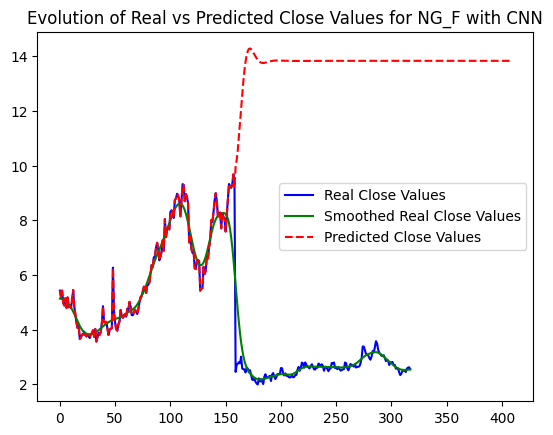

Feature: NG_F - RMSE: 2.7206078295972613
Training for NG_F with configuration rank 2
Epoch 1/1000
53/53 [==============================] - 21s 234ms/step - loss: 2.3580 - val_loss: 1.4209
Epoch 2/1000
53/53 [==============================] - 10s 196ms/step - loss: 1.1946 - val_loss: 1.0264
Epoch 3/1000
53/53 [==============================] - 10s 198ms/step - loss: 0.9735 - val_loss: 0.9046
Epoch 4/1000
53/53 [==============================] - 11s 198ms/step - loss: 0.8792 - val_loss: 0.8220
Epoch 5/1000
53/53 [==============================] - 11s 201ms/step - loss: 0.7997 - val_loss: 0.7611
Epoch 6/1000
53/53 [==============================] - 10s 197ms/step - loss: 0.7429 - val_loss: 0.7061
Epoch 7/1000
53/53 [==============================] - 10s 197ms/step - loss: 0.6913 - val_loss: 0.6580
Epoch 8/1000
53/53 [==============================] - 11s 200ms/step - loss: 0.6407 - val_loss: 0.6078
Epoch 9/1000
53/53 [==============================] - 11s 200ms/step - loss: 0.5926 - val_l

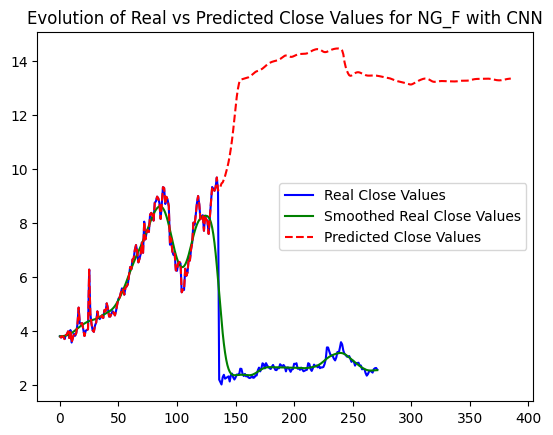

Feature: NG_F - RMSE: 2.637160236563141
Training for NG_F with configuration rank 3
Epoch 1/1000
53/53 [==============================] - 23s 228ms/step - loss: 12.0510 - val_loss: 7.3848
Epoch 2/1000
53/53 [==============================] - 11s 198ms/step - loss: 6.2409 - val_loss: 5.4594
Epoch 3/1000
53/53 [==============================] - 12s 219ms/step - loss: 5.0678 - val_loss: 4.7040
Epoch 4/1000
53/53 [==============================] - 11s 217ms/step - loss: 4.4430 - val_loss: 4.1722
Epoch 5/1000
53/53 [==============================] - 12s 218ms/step - loss: 3.9573 - val_loss: 3.7276
Epoch 6/1000
53/53 [==============================] - 11s 216ms/step - loss: 3.5499 - val_loss: 3.3421
Epoch 7/1000
53/53 [==============================] - 11s 213ms/step - loss: 3.1801 - val_loss: 3.0012
Epoch 8/1000
53/53 [==============================] - 10s 198ms/step - loss: 2.8603 - val_loss: 2.6974
Epoch 9/1000
53/53 [==============================] - 10s 198ms/step - loss: 2.5691 - val_l

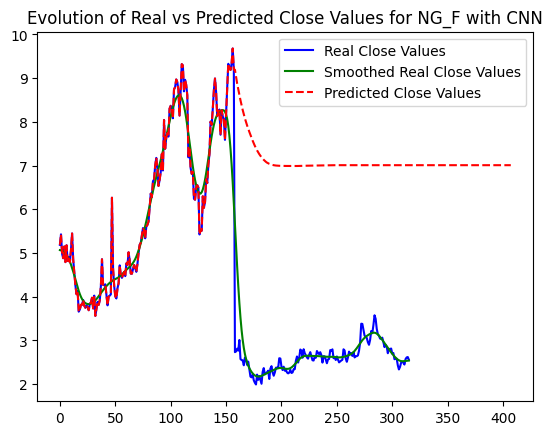

Feature: NG_F - RMSE: 1.1130772831019338
Training for NG_F with configuration rank 4
Epoch 1/1000
53/53 [==============================] - 20s 208ms/step - loss: 1.6055 - val_loss: 1.0059
Epoch 2/1000
53/53 [==============================] - 9s 171ms/step - loss: 0.8326 - val_loss: 0.7037
Epoch 3/1000
53/53 [==============================] - 9s 165ms/step - loss: 0.6581 - val_loss: 0.6066
Epoch 4/1000
53/53 [==============================] - 9s 162ms/step - loss: 0.5876 - val_loss: 0.5522
Epoch 5/1000
53/53 [==============================] - 8s 152ms/step - loss: 0.5431 - val_loss: 0.5114
Epoch 6/1000
53/53 [==============================] - 9s 165ms/step - loss: 0.5031 - val_loss: 0.4750
Epoch 7/1000
53/53 [==============================] - 9s 165ms/step - loss: 0.4646 - val_loss: 0.4394
Epoch 8/1000
53/53 [==============================] - 8s 156ms/step - loss: 0.4304 - val_loss: 0.4128
Epoch 9/1000
53/53 [==============================] - 9s 164ms/step - loss: 0.3979 - val_loss: 0.3

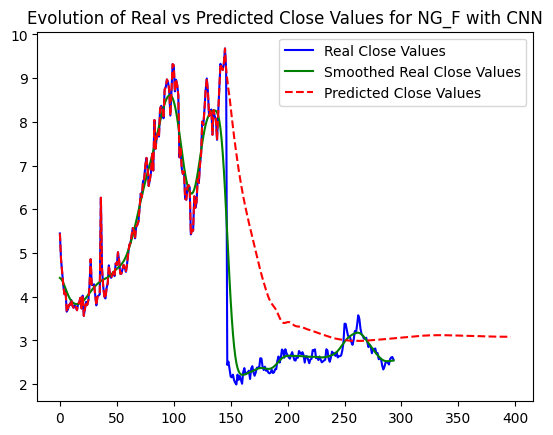

Feature: NG_F - RMSE: 0.3904782333454348
Training for NG_F with configuration rank 5
Epoch 1/1000
53/53 [==============================] - 22s 199ms/step - loss: 3.9842 - val_loss: 2.4849
Epoch 2/1000
53/53 [==============================] - 8s 157ms/step - loss: 1.9860 - val_loss: 1.6658
Epoch 3/1000
53/53 [==============================] - 8s 151ms/step - loss: 1.5260 - val_loss: 1.3845
Epoch 4/1000
53/53 [==============================] - 8s 159ms/step - loss: 1.2960 - val_loss: 1.1858
Epoch 5/1000
53/53 [==============================] - 10s 180ms/step - loss: 1.1145 - val_loss: 1.0183
Epoch 6/1000
53/53 [==============================] - 10s 182ms/step - loss: 0.9576 - val_loss: 0.8768
Epoch 7/1000
53/53 [==============================] - 9s 178ms/step - loss: 0.8225 - val_loss: 0.7497
Epoch 8/1000
53/53 [==============================] - 9s 175ms/step - loss: 0.7093 - val_loss: 0.6440
Epoch 9/1000
53/53 [==============================] - 9s 172ms/step - loss: 0.6267 - val_loss: 0

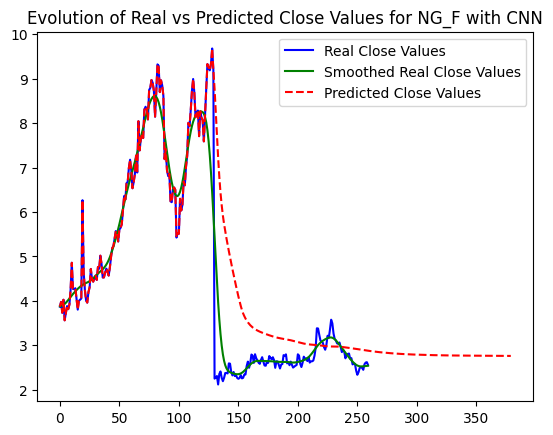

Feature: NG_F - RMSE: 0.2668568010520871
Le meilleur modèle unique est meilleur pour l'indice NG_F. RMSE: 0.2668568010520871
5/5 [==============================] - 0s 66ms/step
Training for NVDA with configuration rank 1
Epoch 1/1000
53/53 [==============================] - 26s 261ms/step - loss: 456.8828 - val_loss: 123.0842
Epoch 2/1000
53/53 [==============================] - 11s 199ms/step - loss: 44.3931 - val_loss: 25.3858
Epoch 3/1000
53/53 [==============================] - 10s 194ms/step - loss: 6.8397 - val_loss: 8.7615
Epoch 4/1000
53/53 [==============================] - 11s 201ms/step - loss: 3.5677 - val_loss: 10.0737
Epoch 5/1000
53/53 [==============================] - 12s 225ms/step - loss: 3.0555 - val_loss: 10.9688
Epoch 6/1000
53/53 [==============================] - 12s 225ms/step - loss: 2.9901 - val_loss: 8.9205
Epoch 7/1000
53/53 [==============================] - 12s 226ms/step - loss: 2.9531 - val_loss: 9.9951
Epoch 8/1000
53/53 [==============================

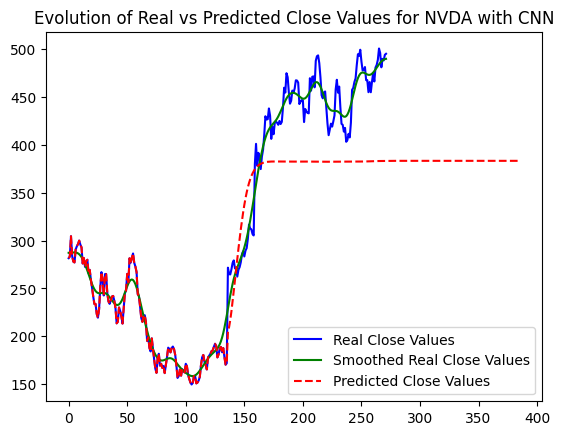

Feature: NVDA - RMSE: 1.1167013612163699
Training for NVDA with configuration rank 2
Epoch 1/1000
53/53 [==============================] - 35s 340ms/step - loss: 3619.7598 - val_loss: 493.0032
Epoch 2/1000
53/53 [==============================] - 15s 277ms/step - loss: 150.2000 - val_loss: 109.8695
Epoch 3/1000
53/53 [==============================] - 15s 282ms/step - loss: 48.0653 - val_loss: 101.0803
Epoch 4/1000
53/53 [==============================] - 17s 326ms/step - loss: 46.4761 - val_loss: 102.0879
Epoch 5/1000
53/53 [==============================] - 17s 323ms/step - loss: 46.4420 - val_loss: 102.1257
Epoch 6/1000
53/53 [==============================] - 17s 327ms/step - loss: 46.2816 - val_loss: 102.0309
Epoch 7/1000
53/53 [==============================] - 16s 309ms/step - loss: 46.2426 - val_loss: 101.1811
Epoch 8/1000
53/53 [==============================] - 16s 303ms/step - loss: 46.2443 - val_loss: 100.6731
Epoch 9/1000
53/53 [==============================] - 16s 304ms/

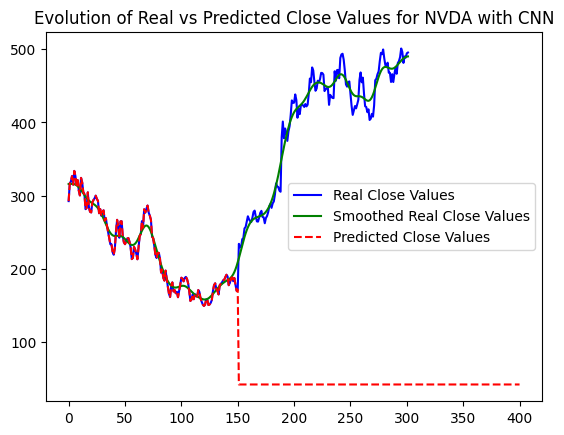

Feature: NVDA - RMSE: 4.739236353305571
Training for NVDA with configuration rank 3
Epoch 1/1000
53/53 [==============================] - 29s 311ms/step - loss: 3064.6316 - val_loss: 497.0657
Epoch 2/1000
53/53 [==============================] - 12s 232ms/step - loss: 132.5394 - val_loss: 90.0524
Epoch 3/1000
53/53 [==============================] - 12s 231ms/step - loss: 33.3741 - val_loss: 86.6462
Epoch 4/1000
53/53 [==============================] - 12s 232ms/step - loss: 31.9508 - val_loss: 85.8503
Epoch 5/1000
53/53 [==============================] - 12s 232ms/step - loss: 31.8803 - val_loss: 87.1055
Epoch 6/1000
53/53 [==============================] - 12s 235ms/step - loss: 31.8361 - val_loss: 86.2705
Epoch 7/1000
53/53 [==============================] - 13s 241ms/step - loss: 31.7926 - val_loss: 85.7006
Epoch 8/1000
53/53 [==============================] - 13s 239ms/step - loss: 31.7593 - val_loss: 86.2154
Epoch 9/1000
53/53 [==============================] - 13s 240ms/step - l

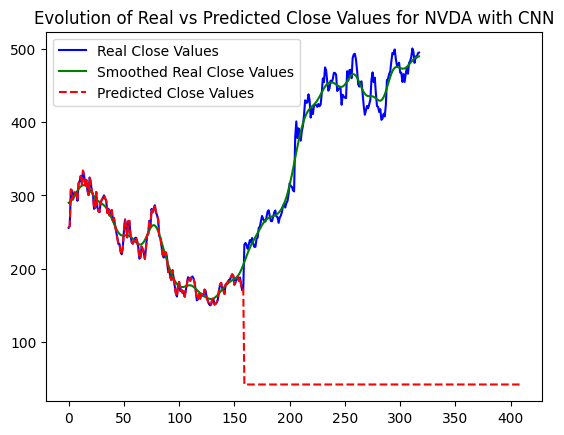

Feature: NVDA - RMSE: 4.594560342357379
Training for NVDA with configuration rank 4
Epoch 1/1000
53/53 [==============================] - 23s 251ms/step - loss: 377.7308 - val_loss: 100.4639
Epoch 2/1000
53/53 [==============================] - 9s 175ms/step - loss: 29.0537 - val_loss: 22.0375
Epoch 3/1000
53/53 [==============================] - 10s 184ms/step - loss: 3.6844 - val_loss: 20.0995
Epoch 4/1000
53/53 [==============================] - 11s 205ms/step - loss: 2.6683 - val_loss: 18.1105
Epoch 5/1000
53/53 [==============================] - 10s 195ms/step - loss: 2.6297 - val_loss: 27.4187
Epoch 6/1000
53/53 [==============================] - 10s 197ms/step - loss: 2.6549 - val_loss: 18.6893
Epoch 7/1000
53/53 [==============================] - 10s 197ms/step - loss: 2.5417 - val_loss: 20.4440
Epoch 8/1000
53/53 [==============================] - 11s 202ms/step - loss: 2.5613 - val_loss: 15.2581
Epoch 9/1000
53/53 [==============================] - 10s 183ms/step - loss: 2.54

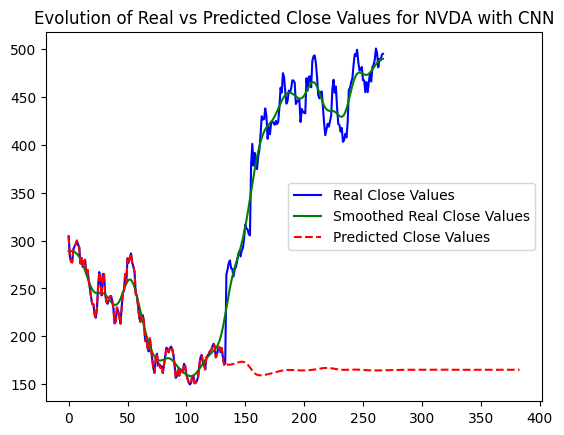

Feature: NVDA - RMSE: 3.398214070880845
Training for NVDA with configuration rank 5
Epoch 1/1000
53/53 [==============================] - 22s 239ms/step - loss: 464.9157 - val_loss: 116.3012
Epoch 2/1000
53/53 [==============================] - 10s 183ms/step - loss: 33.4023 - val_loss: 23.8912
Epoch 3/1000
53/53 [==============================] - 10s 181ms/step - loss: 3.2766 - val_loss: 18.4466
Epoch 4/1000
53/53 [==============================] - 11s 201ms/step - loss: 2.2751 - val_loss: 22.4519
Epoch 5/1000
53/53 [==============================] - 11s 210ms/step - loss: 2.2326 - val_loss: 20.7452
Epoch 6/1000
53/53 [==============================] - 11s 210ms/step - loss: 2.3228 - val_loss: 16.0834
Epoch 7/1000
53/53 [==============================] - 11s 210ms/step - loss: 2.3183 - val_loss: 19.2882
Epoch 8/1000
53/53 [==============================] - 11s 209ms/step - loss: 2.2705 - val_loss: 18.2802
Epoch 9/1000
53/53 [==============================] - 11s 206ms/step - loss: 2.2

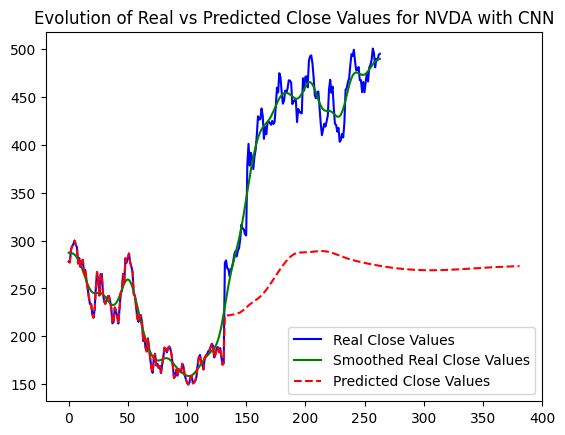

Feature: NVDA - RMSE: 2.0771024597128807
Le meilleur modèle unique est meilleur pour l'indice NVDA. RMSE: 1.1167013612163699
5/5 [==============================] - 3s 151ms/step
Entraînement des modèles de réseau neuronal terminé.


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

def create_single_output_sequences(data, index_name, look_back=1):
    X, y = [], []
    feature_columns = ['Close']
    for i in range(look_back, len(data)):
        sequence_data = data.loc[data.index[i-look_back:i], [(index_name, col) for col in feature_columns]].values
        X.append(sequence_data)
        y.append(data.loc[data.index[i], [(index_name, 'Close')]].values[0])
    return np.array(X), np.array(y)

def recursive_prediction_multi_output(model, initial_input, steps):
    recursive_predictions = []  # Une liste pour stocker les prédictions à chaque étape
    current_input = initial_input.copy()  # Copie de l'entrée initiale pour éviter les modifications indésirables

    for i in range(steps):
        # Faire une prédiction pour le jour suivant en utilisant l'entrée actuelle
        predicted_values = model.predict(current_input.to_numpy().reshape(1, current_input.shape[0], current_input.shape[1]))
        
        # Ajouter ces prédictions à notre liste
        recursive_predictions.append(predicted_values[0])
        
        # Préparer l'entrée pour la prochaine prédiction
        # Supprimer la première valeur (jour le plus ancien)
        current_input = current_input.shift(-1)
        # Ajouter la nouvelle valeur prédite à la fin de l'entrée
        current_input.iloc[-1:] = pd.DataFrame(predicted_values)

    return np.array(recursive_predictions)

# Dictionnaires pour stocker les modèles et leurs performances
gru_models = {}
mse_gru = {}
recursive_preds_gru = {}
all_preds_gru = {}

for index_name in final_df.columns.get_level_values(0).unique():  # Parcourir chaque indice
    # Sélectionner hyperparamètre optimaux
    top_n_params = top_n_trials_per_feature[index_name]
    best_rmse = float('inf') 
    best_model = None
    all_predictions_for_index = []
    
    for rank, best_params in enumerate(top_n_params, 1):
        print(f"Training for {index_name} with configuration rank {rank}")
        look_back=best_params['look_back']

        # Créer des séquences pour l'entraînement et les tests
        X_train, y_train = create_single_output_sequences(train_data, index_name , look_back)
        X_test, y_test = create_single_output_sequences(test_data, index_name ,look_back)

        # Create the neural network model
        model = create_model(
            num_layers=best_params['num_layers'],
            units_per_layer=[2 ** (best_params[f'units_power_{i}']) for i in range(best_params['num_layers'])],
            layer_type=[best_params[f'layer_type_{i}'] for i in range(best_params['num_layers'])],
            dropout_per_layer=[best_params[f'dropout_{i}'] for i in range(best_params['num_layers'])],
            input_shape=(X_train.shape[1], 1),
            use_conv1d=best_params['use_conv1d'],
            conv1d_filters=2 ** best_params['conv1d_filters'] if best_params['use_conv1d'] else None,
            conv1d_kernel_size=best_params.get('conv1d_kernel_size', None),
            use_residual_connection=best_params['use_residual_connection'],
            attention_layer=best_params['use_attention_layer'],
            l1_reg=best_params['l1_reg'],
            l2_reg=best_params['l2_reg']
        )

        # Entraîner le modèle
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=64, callbacks=[early_stopping])

        # Évaluer le modèle

        # Initial input: X dernières observations du jeu de données d'entraînement
        initial_input = train_data[[(index_name, 'Close')]][-look_back:]

        # Prédictions récursives
        predictions = recursive_prediction_multi_output(model, initial_input, len(test_data))
        
        all_predictions_for_index.append(predictions)

        # Initialisation
        inverse_predictions = np.zeros_like(predictions)
        inverse_real_values = np.zeros_like(y_test)

        # Parcourir chaque caractéristique et chaque indice
        for idx, feature_name in enumerate(['Close']):
            scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
            feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant

            # Inverser la mise à l'échelle pour les prédictions et les valeurs réelles
            inverse_predictions = feature_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
            inverse_real_values_test = feature_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

            # Utilisez le scaler pour inverser la mise à l'échelle des dernières valeurs réelles de l'ensemble d'entraînement
            last_real_values_train_scaled = train_data[(index_name, 'Close')].iloc[-len(y_test):].values
            last_real_values_train = feature_scaler.inverse_transform(last_real_values_train_scaled.reshape(-1, 1)).flatten()

            # Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les vraies valeurs de l'ensemble de test
            real_values = np.concatenate([last_real_values_train, inverse_real_values_test])

            # Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les valeurs prédites
            predicted_values = np.concatenate([last_real_values_train, inverse_predictions])
            
            # Appliquer le filtre gaussien
            sigma = 5
            smoothed_values_test = gaussian_filter1d(y_test, sigma)
            smoothed_values = gaussian_filter1d(real_values, sigma)

            rmse = weighted_rmse(smoothed_values_test, np.array(predictions), len(smoothed_values_test))
            if np.std(predictions) > 1e-3:
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    
                    # Stockez les prédictions pour cette caractéristique
                    recursive_preds_gru[scaler_key] = inverse_predictions
            else:
                print("Les prédictions sont constantes.")
            
            plt.plot(real_values, label='Real Close Values', color='blue')
            plt.plot(smoothed_values, label='Smoothed Real Close Values', color='green')
            plt.plot(predicted_values, label='Predicted Close Values', color='red', linestyle='--')
            plt.title(f"Evolution of Real vs Predicted Close Values for {index_name} with CNN")
            plt.legend()
            plt.show()

            # Stocker le modèle et sa performance
            gru_models[scaler_key] = best_model
            mse_gru[scaler_key] = best_rmse
        print(f"Feature: {index_name} - RMSE: {rmse}")
    
    # Calculer la médiane des prédictions pour l'indice
    median_predictions = np.median(all_predictions_for_index, axis=0)
    # Évaluer la RMSE de la médiane des prédiction
    rmse_median = weighted_rmse(smoothed_values_test, np.array(median_predictions), len(smoothed_values_test))
    
        # Comparer la RMSE de la médiane avec la meilleure RMSE individuelle
    if rmse_median < best_rmse:
        print(f"La médiane des prédictions est meilleure pour l'indice {index_name}. RMSE: {rmse_median}")
        recursive_preds_gru[scaler_key] = feature_scaler.inverse_transform(median_predictions.reshape(-1, 1)).flatten()
        mse_gru[scaler_key] = rmse_median
        all_preds_gru[index_name] = median_predictions  # Stocker la médiane des prédictions
    else:
        print(f"Le meilleur modèle unique est meilleur pour l'indice {index_name}. RMSE: {best_rmse}")
        all_preds_gru[index_name] = feature_scaler.inverse_transform(np.array(best_model.predict(X_test)).reshape(-1, 1)).flatten()

print("Entraînement des modèles de réseau neuronal terminé.")

#### Modèle XGBoost:

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # Si les données sont une liste ou un tableau 1D, les convertir en DataFrame
    if type(data) is list or len(data.shape) == 1:
        df = pd.DataFrame(data)
        n_vars = 1
    else:
        df = pd.DataFrame(data)
        n_vars = data.shape[1]
    cols, names = list(), list()
    # Séquence d'entrée (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Séquence de prévision (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Concaténer le tout
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Supprimer les lignes avec des valeurs NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def recursive_prediction_xgb(model, initial_input, steps):
    current_input = np.array(initial_input)
    predictions = []
    for _ in range(steps):
        predicted_values = model.predict(current_input.reshape(1, -1))
        predictions.append(predicted_values)
        current_input = np.roll(current_input, -1)
        current_input[-1:] = predicted_values
    return np.array(predictions)

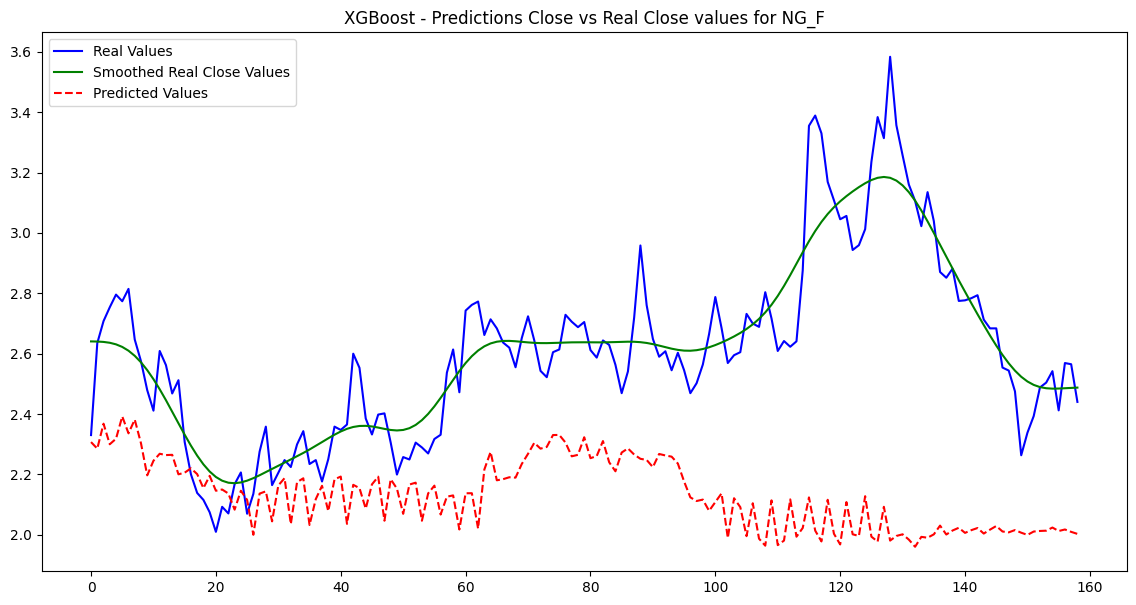

Feature: NG_F - RMSE: 0.11022424549191737


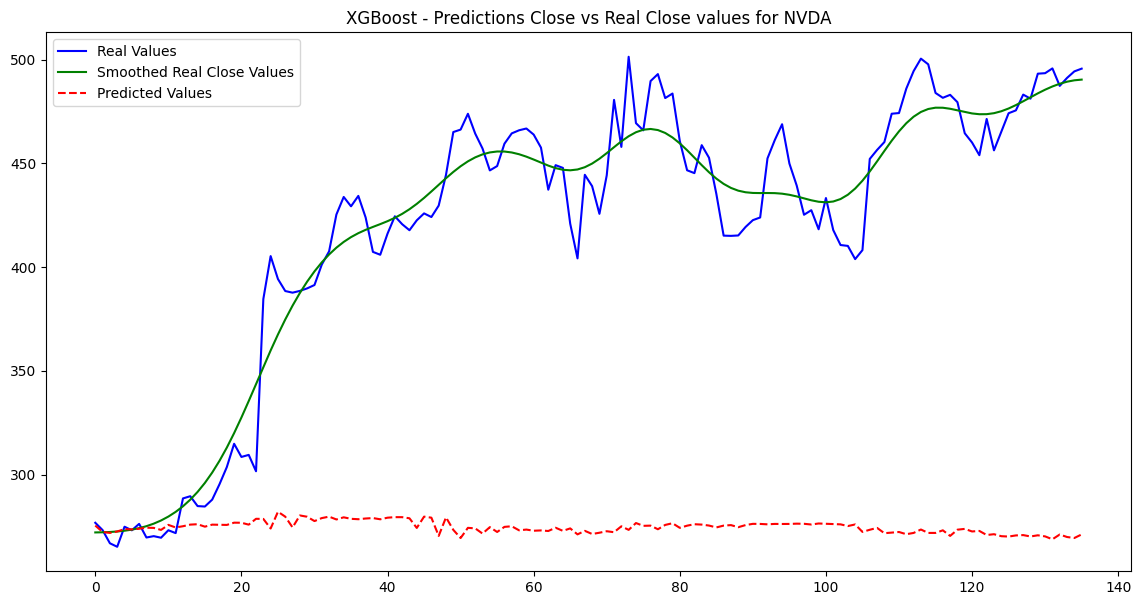

Feature: NVDA - RMSE: 1.9262534183285265
Entraînement des modèles XGBoost terminé.


In [19]:
# Dictionnaires pour stocker les modèles XGBoost et leurs performances
xgb_models = {}
mse_xgb = {}
recursive_preds_xgb = {}

for index_name in final_df.columns.get_level_values(0).unique():
    
    # Sélectionner look_back optimal
    best_params = best_params_per_feature[index_name]
    look_back = best_params['look_back']
    
    # Préparer les données pour XGBoost
    # Créer un indexeur
    idx = pd.IndexSlice

    # Utiliser cet indexeur pour récupérer les données
    values = scaled_data_df.filter(like=index_name, axis=1).values
    data = series_to_supervised(values, look_back, 1)
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    # Diviser en entrées et sorties
    
    X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, -1].values
    X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1].values
    
    # Modèle XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
    model.fit(X_train, y_train)
    
    # Prédictions
    initial_input = X_test[0]
    predictions = recursive_prediction_xgb(model, initial_input, len(y_test))
    
    for idx, feature_name in enumerate(['Close']):
        scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
        feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant
    
        # Inversez la mise à l'échelle

        inverse_predictions = feature_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        inverse_real_values = feature_scaler.inverse_transform(y_test.reshape(-1, 1))
        
        # Appliquer le filtre gaussien
        sigma = 5
        smoothed_values_test = gaussian_filter1d(y_test, sigma)
        smoothed_values = gaussian_filter1d(y_test, sigma)
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
        # Afficher les graphiques
        plt.figure(figsize=(14,7))

        # Tracez les valeurs réelles
        plt.plot(inverse_real_values, label='Real Values', color='blue')
        
        plt.plot(smoothed_values_test, label='Smoothed Real Close Values', color='green')

        # Tracez les prédictions
        plt.plot(inverse_predictions, label='Predicted Values', color='red', linestyle='--')

        plt.title(f"XGBoost - Predictions Close vs Real Close values for {index_name}")
        plt.legend()
        plt.show()

        # Évaluer le modèle
        rmse = weighted_rmse(smoothed_values, np.array(predictions), len(smoothed_values))

        # Stocker le modèle et sa performance
        xgb_models[scaler_key] = model
        mse_xgb[scaler_key] = rmse
        recursive_preds_xgb[scaler_key] = inverse_predictions
        print(f"Feature: {index_name} - RMSE: {rmse}")

print("Entraînement des modèles XGBoost terminé.")

#### Modèle SARIMA:

In [20]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", "Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", "Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.")
"""# Dictionnaires pour stocker les modèles SARIMA et leurs performances
sarima_models = {}
mse_sarima = {}
recursive_preds_sarima = {}

for index_name in final_df.columns.get_level_values(0).unique():
    def objective_sarima(trial):
        # Paramètres à optimiser
        p = trial.suggest_int('p', 0, 5)
        d = trial.suggest_int('d', 0, 1)
        q = trial.suggest_int('q', 0, 4)
        P = trial.suggest_int('P', 0, 5)
        D = trial.suggest_int('D', 0, 1)
        Q = trial.suggest_int('Q', 0, 4)
        s = trial.suggest_int('s', 2, 12)  # saisonnalité

        # Validation des hyperparamètres
        if p == P:
            return float('inf')  # retourne une valeur infinie pour indiquer un mauvais essai

        try:
            # Création du modèle SARIMA
            sarima = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
            sarima_fit = sarima.fit(disp=False, maxiter=300, method='bfgs')

            # Prédictions
            predictions = sarima_fit.forecast(steps=len(y_test))
            
            if not np.std(predictions) > 1e-3:
                return float('inf')  # Rejeter le modèle si les prédictions sont constantes
            
            smoothed_values_test = gaussian_filter1d(y_test, sigma)

            # Calcul de la RMSE
            rmse = weighted_rmse(smoothed_values_test, predictions, len(smoothed_values_test))

            return rmse

        except Exception as e:  # Attrape toutes les exceptions, y compris les problèmes de convergence ou les erreurs de spécification du modèle
            return float('inf')  # retourne une valeur infinie pour indiquer un mauvais essai

    # Sélectionner look_back optimal
    best_params = best_params_per_feature[index_name]
    look_back = best_params['look_back']
    
    # Préparer les données pour XGBoost
    # Créer un indexeur
    idx = pd.IndexSlice

    # Utiliser cet indexeur pour récupérer les données
    values = scaled_data_df.filter(like=index_name, axis=1).values
    data = series_to_supervised(values, look_back, 1)
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    # Diviser en entrées et sorties
    
    X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, -1].values
    X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1].values
    
    
    # Création d'une étude Optuna
    study_sarima = optuna.create_study(direction='minimize')
    study_sarima.optimize(objective_sarima, n_trials=50)
    
    best_params = study_sarima.best_params
    best_rmse = study_sarima.best_value

    # Modèle SARIMA avec les meilleurs hyperparamètres
    best_model = SARIMAX(y_train, 
                          order=(best_params['p'], best_params['d'], best_params['q']), 
                          seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']))
    best_model_fit = best_model.fit(disp=False, maxiter=200, method='bfgs')
    
    # Meilleures prédictions
    best_predictions = best_model_fit.forecast(steps=len(y_test))
    
    for idx, feature_name in enumerate(['Close']):
        scaler_key = (index_name, feature_name)  # Créer la clé pour accéder au bon scaler dans le dictionnaire
        feature_scaler = scalers_dict[scaler_key]  # Récupérer le scaler correspondant
        
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
    
        # Inversez la mise à l'échelle

        inverse_predictions = feature_scaler.inverse_transform(np.array(best_predictions).reshape(-1, 1))
        inverse_real_values = feature_scaler.inverse_transform(y_test.reshape(-1, 1))
        
        
        # Appliquer le filtre gaussien
        sigma = 5
        smoothed_values_test = gaussian_filter1d(y_test, sigma)
        smoothed_values = gaussian_filter1d(y_test, sigma)
        smoothed_values_test = feature_scaler.inverse_transform(smoothed_values_test.reshape(-1, 1))
        
        # Affichage des graphiques
        plt.figure(figsize=(14,7))
        plt.plot(inverse_real_values, label='Real Values', color='blue')
        plt.plot(smoothed_values_test, label='Smoothed Real Close Values', color='green')
        plt.plot(inverse_predictions, label='Predicted Values', color='red', linestyle='--')
        plt.title(f"SARIMA - Best Predictions vs Real values for {index_name}")
        plt.legend()
        plt.show()

        # Stocker le modèle et sa performance
        sarima_models[scaler_key] = best_model
        mse_sarima[scaler_key] = best_rmse
        recursive_preds_sarima[scaler_key] = inverse_predictions

        print(f"Feature: {index_name} - Best RMSE: {best_rmse}")
        
print("Entraînement des modèles SARIMA terminé.")
"""
print("SARIMA passé")

SARIMA passé


### Choix du modèle par features

In [21]:
features_choice_df = pd.DataFrame({"GRU": mse_gru})

best_model_per_feature = features_choice_df.idxmin(axis=1).to_frame(name='Best Model')
best_model_per_feature['MSE'] = features_choice_df.min(axis=1)


print(best_model_per_feature)

           Best Model       MSE
NG_F Close        GRU  0.266857
NVDA Close        GRU  1.116701


### Filtrage : comparaison avec un modèle naif

Ce n'est parce que un modèle est meilleurs que les autres qu'il est réellement pertinant, la comparaison avec un modèle naif/simpliste indiquera si le modèle est réelement performant (et pas seulement par rapport aux autres)

In [22]:
# Créer un dictionnaire avec les données de test pour chaque feature
test_data_dict = {}
for feature in scaled_data_df.columns:
    test_data_dict[feature] = test_data[feature]
    
# Dictionnaire pour regrouper toutes les prédictions récursives
all_recursive_preds = {
    'GRU': recursive_preds_gru,
}

def naive_recursive_forecast(series, steps):
    """Génère des prédictions récursives en utilisant la dernière valeur connue pour `steps` prédictions."""
    predictions = [series[-1]]  # on commence avec la dernière observation
    for _ in range(steps-1):
        predictions.append(predictions[-1])
    return np.array(predictions)

mse_naive_recursive_dict = {}

for index_name in final_df.columns.get_level_values(0).unique():
    
    # Récupérer les valeurs réelles de l'indice spécifique
    actual_values = test_data_dict[(index_name, 'Close')].values[1:]
    
    # Générer des prédictions naïves pour l'indice spécifique
    naive_predictions = naive_recursive_forecast(test_data_dict[(index_name, 'Close')].values[:-1], len(actual_values))
    
    # Calculer le MSE pour ces prédictions naïves
    mse_naive_recursive = mean_squared_error(actual_values, naive_predictions)
    
    # Stocker ce MSE dans le dictionnaire
    mse_naive_recursive_dict[index_name] = mse_naive_recursive
    
    # Récupérer les valeurs réelles, les prédictions du modèle et les prédictions naïves
    best_model_name = best_model_per_feature.loc[(index_name, 'Close'), 'Best Model']
    best_model_predictions = all_recursive_preds[best_model_name][(index_name, 'Close')]
    
    actual_values = data.values
    naive_predictions = naive_recursive_forecast(data.values[:-1], len(actual_values))

# Comparer les MSE des modèles et des prévisions naïves récursives
comparison_recursive_dict = {}
for feature, row in best_model_per_feature.iterrows():
    comparison_recursive_dict[feature] = {
        'Model MSE': row['MSE'],
        'Naive Recursive MSE': mse_naive_recursive_dict[feature[0]],
        'Model is Better': row['MSE'] < mse_naive_recursive_dict[feature[0]]
    }

comparison_recursive_dict

{('NG_F', 'Close'): {'Model MSE': 0.2668568010520871,
  'Naive Recursive MSE': 0.5302463177733041,
  'Model is Better': True},
 ('NVDA', 'Close'): {'Model MSE': 1.1167013612163699,
  'Naive Recursive MSE': 20.968012706060513,
  'Model is Better': True}}

### Conclusion sur les features finales

In [23]:
# Vérifier pour quelles features le modèle naïf est meilleur
naive_better_features = [feature for feature, values in comparison_recursive_dict.items() if not values['Model is Better']]

# Afficher un message d'avertissement pour ces features
if naive_better_features:
    print("Avertissement : Pour les features suivantes, le modèle naïf a performé mieux que le modèle choisi :")
    for feature in naive_better_features:
        print(f"- {feature}")

# Modèle final : basé sur les précédentes features

#### Préparation des données

In [24]:
final_features  = []
for model_type in all_recursive_preds:
    for feature in comparison_recursive_dict:
        print("for : " + str(feature) + "/" + str(model_type) + ":" + str(all_recursive_preds[model_type][feature][0]))
        
for feature in comparison_recursive_dict:
    final_features.append(feature)

# Initialiser le dictionnaire pour stocker les scalers pour chaque feature
final_scalers = {}
print(final_features)
# Mettre à l'échelle les données pour chaque feature
final_features_with_sp500 = final_features + [('GSPC', 'Open')] + [('GSPC', 'Close')]
final_combined_data = combined_data[final_features_with_sp500].copy()

print("Combined data shape:", combined_data.shape)

for feature in final_features:
    scaler = MinMaxScaler()
    final_combined_data[feature] = scaler.fit_transform(final_combined_data[feature].values.reshape(-1, 1))
    final_scalers[feature] = scaler

# Mettre à l'échelle le SP500
sp500_scaler = RobustScaler()
final_combined_data[('GSPC', 'Open')] = sp500_scaler.fit_transform(final_combined_data[('GSPC', 'Open')].values.reshape(-1, 1))
final_combined_data[('GSPC', 'Close')] = sp500_scaler.fit_transform(final_combined_data[('GSPC', 'Close')].values.reshape(-1, 1))

final_combined_data.tail()

for : ('NG_F', 'Close')/GRU:8.780438
for : ('NVDA', 'Close')/GRU:204.3203
[('NG_F', 'Close'), ('NVDA', 'Close')]
Combined data shape: (3721, 76)


NG_F      NVDA      GSPC          
               Close     Close      Open     Close
Date                                              
2023-12-20  0.062360  0.960679  1.893126  1.849365
2023-12-21  0.071423  0.978259  1.866879  1.880763
2023-12-22  0.074179  0.975059  1.886110  1.885875
2023-12-27  0.074831  0.986800  1.898786  1.903359
2023-12-28  0.070336  0.988900  1.907217  1.904507

# Etudes des paramètres optimaux du modèle final

In [25]:
early_stopping = EarlyStopping(monitor='val_mean_directional_accuracy', mode='max', patience=10, restore_best_weights=True)

def mean_directional_accuracy(y_true, y_pred):
    # Obtenir la forme du tenseur y_true (ou y_pred, de même forme)
    y_shape = K.shape(y_true)

    # Calculer le nombre d'échantillons dans ce lot
    batch_size = y_shape[0]

    # Calculer le nombre de blocs de 10 que nous pouvons avoir
    num_blocks = batch_size // 10

    # Calculer le nombre d'échantillons à garder pour avoir un multiple de 10
    keep_samples = num_blocks * 10

    # Tronquer les tenseurs pour avoir un multiple de 10
    y_true = y_true[:keep_samples]
    y_pred = y_pred[:keep_samples]

    # Si keep_samples est 0, retourner 0 comme métrique
    if keep_samples == 0:
        return K.constant(0, dtype='float32')

    # Réorganiser en blocs de 10
    y_true_reshaped = K.reshape(y_true, (-1, 10))
    y_pred_reshaped = K.reshape(y_pred, (-1, 10))

    # Calculer la différence entre le premier et le dernier élément de chaque bloc
    true_diff = y_true_reshaped[:, -1] - y_true_reshaped[:, 0]
    pred_diff = y_pred_reshaped[:, -1] - y_pred_reshaped[:, 0]

    # Comparer les signes
    matches = K.equal(K.sign(true_diff), K.sign(pred_diff))

    # Calculer la précision directionnelle moyenne
    accuracy = K.mean(K.cast(matches, dtype='float32'))

    return accuracy

def create_sequences(data, look_back=100):
    X, y = [], []
    total_data_points = len(data) // 2 * 2  # Pour s'assurer que nous avons un nombre pair de jours à considérer
    
    for i in range(look_back, total_data_points - 1, 1):  # On avance de un en un pour prendre en compte chaque jour
        sequence_data_open = []
        sequence_data_close = []

        # Ajouter les valeurs d'ouverture et de clôture, alternées
        for j in range(i - look_back, i):
            sequence_data_open.append([data[j, -2]])  # Valeur d'ouverture
            sequence_data_close.append([data[j, -1]])  # Valeur de clôture

        # Séquence pour les autres features
        other_features_seq = data[i - look_back:i, :-2]

        # Double chaque valeur de clôture prédite pour les autres features
        other_features_seq_doubled_open = np.repeat(other_features_seq, 1, axis=0)
        other_features_seq_doubled_close = np.repeat(other_features_seq, 1, axis=0)

        # Combinez les séquences
        combined_seq_open = np.hstack([other_features_seq_doubled_open, sequence_data_open])
        combined_seq_close = np.hstack([other_features_seq_doubled_close, sequence_data_close])

        X.append(combined_seq_open)  # Remodeler pour avoir look_back x (nombre de features - 1)
        y.append(data[i, -1])  # Clôture du jour i

        X.append(combined_seq_close)  # Remodeler pour avoir look_back x (nombre de features - 1)
        y.append(data[i + 1, -2])  # Ouverture du jour i+1

    return np.array(X), np.array(y)

def create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, input_shape, use_conv1d , conv1d_filters ,conv1d_kernel_size ,use_residual_connection, attention_layer, l1_reg, l2_reg):
    inputs = Input(shape=input_shape)
    x = inputs
    if use_conv1d:
        x = Conv1D(conv1d_filters, kernel_size=conv1d_kernel_size, activation='relu')(x)
    if layer_type[0] == "GRU":
        x = Bidirectional(GRU(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    elif layer_type[0] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[0], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
    x = Dropout(dropout_per_layer[0])(x)
    for i in range(1, num_layers):
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x_res = x
        if layer_type[i] == "GRU":
            x = Bidirectional(GRU(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        elif layer_type[i] == "LSTM":
            x = Bidirectional(LSTM(units_per_layer[i], return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))(x)
        x = Dropout(dropout_per_layer[i])(x)
        if attention_layer:
            x = Attention(use_scale=True)([x, x])
        if use_residual_connection and units_per_layer[i] == units_per_layer[i-1]:
            x = Add()([x, x_res])
    if layer_type[num_layers-1] == "GRU":
        x = Bidirectional(GRU(units_per_layer[num_layers-1]))(x)
    elif layer_type[num_layers-1] == "LSTM":
        x = Bidirectional(LSTM(units_per_layer[num_layers-1]))(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[mean_directional_accuracy])
    return model

# Fonction pour réaliser une prédiction récursive avec le modèle final
def recursive_prediction_final_model(model, initial_input, steps, best_model_per_feature, final_scalers, look_back):
    recursive_predictions = []
    current_input = initial_input.copy()

    for step in range(steps):
        # Utilisez les X derniers jours (qu'ils soient réels ou prédits) pour faire la prédiction
        input_for_prediction = current_input[-look_back:]
        
        # Prédire la prochaine valeur du SP500 en utilisant le modèle final
        predicted_sp500_values = model.predict(input_for_prediction.reshape(1, look_back, input_for_prediction.shape[1]), verbose=0)
        recursive_predictions.append(predicted_sp500_values)

        # Mettez à jour l'entrée pour la prochaine prédiction en utilisant les meilleurs modèles pour chaque caractéristique
        new_input_row = []
        for feature in final_features:
            model_type = best_model_per_feature['Best Model'][feature]
            predicted_feature_value = all_recursive_preds[model_type][feature][step//2]

            # Mettez à l'échelle la caractéristique prédite
            scaled_feature_prediction = final_scalers[feature].transform(np.array(predicted_feature_value).reshape(-1, 1))
            new_input_row.append(scaled_feature_prediction[0][0])

        # Utilisez deux fois la valeur de clôture prédite pour les autres indices comme entrée
        #new_input_row = [item for item in new_input_row for _ in range(2)]

        # Ajouter les valeurs prédites ajustées pour le S&P 500
        new_input_row.append(predicted_sp500_values[0, 0])

        # Mettez à jour l'entrée pour la prochaine prédiction
        current_input = np.vstack([current_input[1:], np.array(new_input_row)])

    return np.array(recursive_predictions)

def objective(trial):

    # Espace de recherche
    ###############################################################################################
    look_back = trial.suggest_int('look_back', int(test_size/3), int(test_size/2) - 1)
    num_layers = trial.suggest_int('num_layers', 3, 9)
    layer_type = [trial.suggest_categorical(f'layer_type_{i}', ['LSTM', 'GRU']) for i in range(num_layers)]
    units_per_layer = [trial.suggest_int(f'units_power_{i}', 7, 9) for i in range(num_layers)]
    units_per_layer = [2 ** power for power in units_per_layer]
    dropout_per_layer = [trial.suggest_float(f'dropout_{i}', 0.1, 0.3) for i in range(num_layers)]
    use_residual_connection = trial.suggest_categorical('use_residual_connection', [True, False])
    attention_layer = trial.suggest_categorical('use_attention_layer', [True, False])
    use_conv1d = trial.suggest_categorical('use_conv1d', [False, True])
    if use_conv1d:
        conv1d_filters = trial.suggest_int('conv1d_filters', 5, 7)
        conv1d_filters = 2 ** conv1d_filters
        conv1d_kernel_size = trial.suggest_int('conv1d_kernel_size', 3, 7)
    l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-1, log=True)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-1, log=True)
    ################################################################################################
    
    # Créez des séquences en utilisant look_back
    X_train, y_train = create_sequences(final_combined_data.iloc[:train_size].values, look_back)
    X_test, y_test = create_sequences(final_combined_data.iloc[train_size:].values, look_back)
    
    n_splits = 5  # Nombre de splits
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    val_loss_list = []  # Liste pour stocker la val_loss de chaque split
        
    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        if use_conv1d:
            model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), (len(reduced_df.columns) + 1)), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)
        else:
            conv1d_filters = 36
            conv1d_kernel_size = 5
            model = create_model(num_layers, layer_type, units_per_layer, dropout_per_layer, ((look_back), (len(reduced_df.columns) + 1)), use_conv1d, conv1d_filters, conv1d_kernel_size, use_residual_connection, attention_layer, l1_reg, l2_reg)

        recursive_predictions = []
        
        input_sequence = X_val_fold[0].reshape(1, look_back, len(reduced_df.columns) + 1)

        history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=15, batch_size=32, verbose=0, callbacks=[early_stopping])
        
        # Obtenez la val_loss du dernier epoch
        last_val_loss = history.history['val_loss'][-1]
        val_loss_list.append(last_val_loss)
    
    mean_val_loss = np.mean(val_loss_list)  # Moyenne des val_loss sur tous les plis
    
    initial_input = X_val_fold[0]
    recursive_predictions = recursive_prediction_final_model(model, initial_input, look_back, best_model_per_feature, final_scalers, look_back) #prédictions que sur le dernier pli
    if not np.std(recursive_predictions[:, 0][:, 0]) > 1e-3:
        return float('inf')  # Rejeter le modèle si les prédictions sont constantes
    return mean_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params_final = study.best_params
top_5_trials = sorted(study.trials, key=lambda trial: trial.value)[:5]

# Affichage des résultats
print('Number of finished trials: ', len(study.trials))
for i, trial in enumerate(top_5_trials):
    print(f'Rank {i+1} - Value: {trial.value}, Params: {trial.params}')

[I 2024-01-04 08:06:23,581] A new study created in memory with name: no-name-4833c6af-36d9-448a-81ee-5b56ca742ce3
[I 2024-01-04 08:40:53,355] Trial 0 finished with value: inf and parameters: {'look_back': 102, 'num_layers': 9, 'layer_type_0': 'LSTM', 'layer_type_1': 'LSTM', 'layer_type_2': 'GRU', 'layer_type_3': 'LSTM', 'layer_type_4': 'GRU', 'layer_type_5': 'LSTM', 'layer_type_6': 'GRU', 'layer_type_7': 'LSTM', 'layer_type_8': 'LSTM', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'units_power_3': 8, 'units_power_4': 8, 'units_power_5': 7, 'units_power_6': 8, 'units_power_7': 9, 'units_power_8': 9, 'dropout_0': 0.26561056540511974, 'dropout_1': 0.21973238783047438, 'dropout_2': 0.2607134658475496, 'dropout_3': 0.19729524198665604, 'dropout_4': 0.24049349427624575, 'dropout_5': 0.27337386642336037, 'dropout_6': 0.2316513116065031, 'dropout_7': 0.2513520432979615, 'dropout_8': 0.14671604433536356, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': 

Number of finished trials:  50
Rank 1 - Value: 0.062485873140394686, Params: {'look_back': 101, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'dropout_0': 0.26829485089943433, 'dropout_1': 0.2024027743205687, 'dropout_2': 0.21929909316250523, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 1.4046229015021427e-05, 'l2_reg': 0.001774736529985167}
Rank 2 - Value: 0.06738018905743956, Params: {'look_back': 101, 'num_layers': 3, 'layer_type_0': 'GRU', 'layer_type_1': 'GRU', 'layer_type_2': 'GRU', 'units_power_0': 8, 'units_power_1': 9, 'units_power_2': 7, 'dropout_0': 0.27337403912584185, 'dropout_1': 0.2142904176943158, 'dropout_2': 0.21642542955056052, 'use_residual_connection': False, 'use_attention_layer': True, 'use_conv1d': True, 'conv1d_filters': 5, 'conv1d_kernel_size': 3, 'l1_reg': 1.3491010261

#### Création du modèle

Epoch 1/1000
211/211 [==============================] - 26s 90ms/step - loss: 1.0385 - mean_directional_accuracy: 0.9431 - val_loss: 0.1542 - val_mean_directional_accuracy: 0.5333
Epoch 2/1000
211/211 [==============================] - 17s 81ms/step - loss: 0.0588 - mean_directional_accuracy: 0.9558 - val_loss: 0.0590 - val_mean_directional_accuracy: 0.5333
Epoch 3/1000
211/211 [==============================] - 17s 80ms/step - loss: 0.0243 - mean_directional_accuracy: 0.9526 - val_loss: 0.0201 - val_mean_directional_accuracy: 0.5333
Epoch 4/1000
211/211 [==============================] - 17s 81ms/step - loss: 0.0170 - mean_directional_accuracy: 0.9447 - val_loss: 0.0598 - val_mean_directional_accuracy: 0.5333
Epoch 5/1000
211/211 [==============================] - 17s 82ms/step - loss: 0.0143 - mean_directional_accuracy: 0.9494 - val_loss: 0.0309 - val_mean_directional_accuracy: 0.5667
Epoch 6/1000
211/211 [==============================] - 17s 82ms/step - loss: 0.0145 - mean_directio

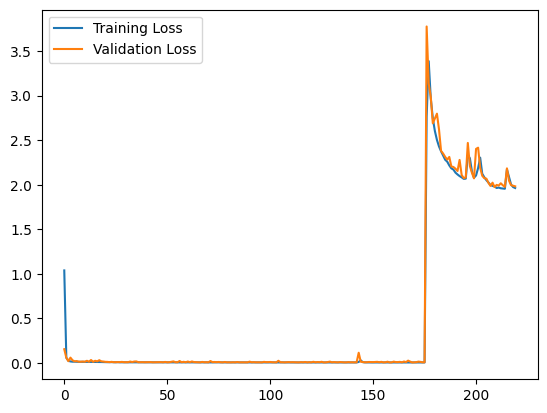

Epoch 1/1000
211/211 [==============================] - 27s 98ms/step - loss: 1.6900 - mean_directional_accuracy: 0.9447 - val_loss: 0.7649 - val_mean_directional_accuracy: 0.5333
Epoch 2/1000
211/211 [==============================] - 18s 87ms/step - loss: 0.4150 - mean_directional_accuracy: 0.9573 - val_loss: 0.3111 - val_mean_directional_accuracy: 0.5333
Epoch 3/1000
211/211 [==============================] - 17s 82ms/step - loss: 0.1689 - mean_directional_accuracy: 0.9463 - val_loss: 0.1400 - val_mean_directional_accuracy: 0.5333
Epoch 4/1000
211/211 [==============================] - 18s 84ms/step - loss: 0.0824 - mean_directional_accuracy: 0.9463 - val_loss: 0.1296 - val_mean_directional_accuracy: 0.5333
Epoch 5/1000
211/211 [==============================] - 18s 84ms/step - loss: 0.0467 - mean_directional_accuracy: 0.9479 - val_loss: 0.0790 - val_mean_directional_accuracy: 0.5333
Epoch 6/1000
211/211 [==============================] - 17s 83ms/step - loss: 0.0300 - mean_directio

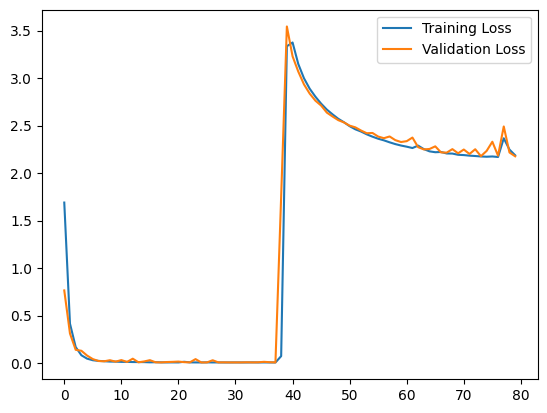

Epoch 1/1000
211/211 [==============================] - 26s 96ms/step - loss: 1.0603 - mean_directional_accuracy: 0.9573 - val_loss: 0.3021 - val_mean_directional_accuracy: 0.5667
Epoch 2/1000
211/211 [==============================] - 19s 88ms/step - loss: 0.0659 - mean_directional_accuracy: 0.9573 - val_loss: 0.0359 - val_mean_directional_accuracy: 0.5333
Epoch 3/1000
211/211 [==============================] - 18s 85ms/step - loss: 0.0254 - mean_directional_accuracy: 0.9716 - val_loss: 0.0196 - val_mean_directional_accuracy: 0.5333
Epoch 4/1000
211/211 [==============================] - 17s 82ms/step - loss: 0.0176 - mean_directional_accuracy: 0.9431 - val_loss: 0.0408 - val_mean_directional_accuracy: 0.5333
Epoch 5/1000
211/211 [==============================] - 17s 82ms/step - loss: 0.0162 - mean_directional_accuracy: 0.9431 - val_loss: 0.0171 - val_mean_directional_accuracy: 0.5333
Epoch 6/1000
211/211 [==============================] - 18s 84ms/step - loss: 0.0149 - mean_directio

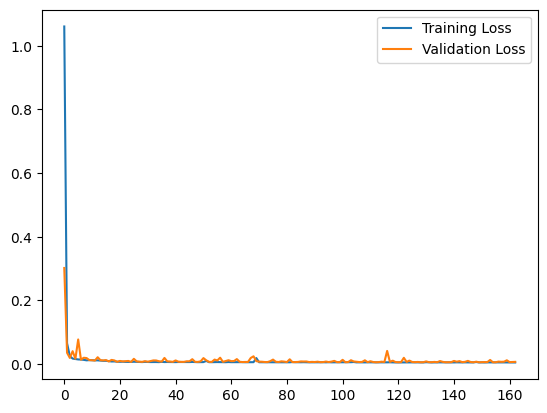

Epoch 1/1000
211/211 [==============================] - 26s 93ms/step - loss: 0.8933 - mean_directional_accuracy: 0.9526 - val_loss: 0.0753 - val_mean_directional_accuracy: 0.5333
Epoch 2/1000
211/211 [==============================] - 18s 84ms/step - loss: 0.0340 - mean_directional_accuracy: 0.9700 - val_loss: 0.0290 - val_mean_directional_accuracy: 0.5333
Epoch 3/1000
211/211 [==============================] - 17s 83ms/step - loss: 0.0188 - mean_directional_accuracy: 0.9637 - val_loss: 0.0838 - val_mean_directional_accuracy: 0.5333
Epoch 4/1000
211/211 [==============================] - 18s 85ms/step - loss: 0.0148 - mean_directional_accuracy: 0.9542 - val_loss: 0.0340 - val_mean_directional_accuracy: 0.5667
Epoch 5/1000
211/211 [==============================] - 18s 85ms/step - loss: 0.0147 - mean_directional_accuracy: 0.9573 - val_loss: 0.0698 - val_mean_directional_accuracy: 0.5667
Epoch 6/1000
211/211 [==============================] - 18s 84ms/step - loss: 0.0135 - mean_directio

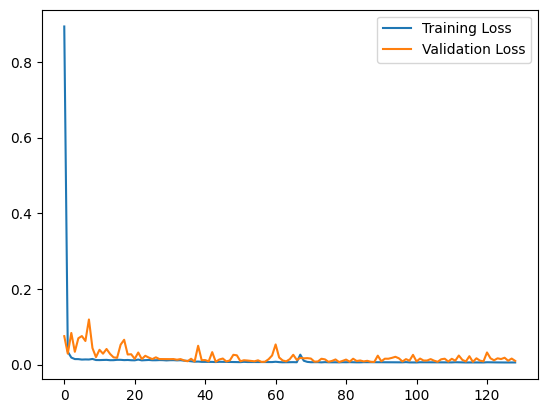

Epoch 1/1000
211/211 [==============================] - 25s 91ms/step - loss: 1.1341 - mean_directional_accuracy: 0.9510 - val_loss: 0.2068 - val_mean_directional_accuracy: 0.5333
Epoch 2/1000
211/211 [==============================] - 18s 84ms/step - loss: 0.0905 - mean_directional_accuracy: 0.9415 - val_loss: 0.0427 - val_mean_directional_accuracy: 0.5333
Epoch 3/1000
211/211 [==============================] - 18s 83ms/step - loss: 0.0309 - mean_directional_accuracy: 0.9573 - val_loss: 0.0224 - val_mean_directional_accuracy: 0.5333
Epoch 4/1000
211/211 [==============================] - 18s 84ms/step - loss: 0.0200 - mean_directional_accuracy: 0.9589 - val_loss: 0.0905 - val_mean_directional_accuracy: 0.5333
Epoch 5/1000
211/211 [==============================] - 18s 85ms/step - loss: 0.0163 - mean_directional_accuracy: 0.9447 - val_loss: 0.0167 - val_mean_directional_accuracy: 0.5333
Epoch 6/1000
211/211 [==============================] - 21s 99ms/step - loss: 0.0157 - mean_directio

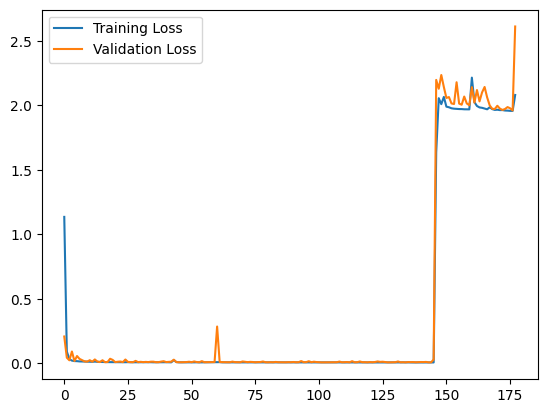

In [26]:
all_predictions = []
final_close_predictions = []
final_models = []
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



for i, trial in enumerate(top_5_trials):
    best_params = trial.params
    
    # Créer le modèle de réseau neuronal
    final_model = create_model(
            num_layers = best_params_final['num_layers'],
            units_per_layer=[2 ** (best_params_final[f'units_power_{i}']) for i in range(int(best_params_final['num_layers']))],
            layer_type=[best_params_final[f'layer_type_{i}'] for i in range(best_params_final['num_layers'])],
            dropout_per_layer=[best_params_final[f'dropout_{i}'] for i in range(best_params_final['num_layers'])],
            input_shape=((best_params_final['look_back']), (len(reduced_df.columns) + 1)),
            use_conv1d=best_params_final['use_conv1d'],
            conv1d_filters=2 ** best_params_final.get('conv1d_filters', 0),
            conv1d_kernel_size=best_params_final.get('conv1d_kernel_size', None),
            use_residual_connection=best_params_final['use_residual_connection'],
            attention_layer=best_params_final['use_attention_layer'],
            l1_reg=best_params_final['l1_reg'],
            l2_reg=best_params_final['l2_reg']
    )
    
    #Création de séquences

    X_train_final, y_train_final = create_sequences(final_combined_data.iloc[:train_size].values, best_params_final['look_back'])
    X_test_final, y_test_final = create_sequences(final_combined_data.iloc[train_size:].values, best_params_final['look_back'])

    history = final_model.fit(
        X_train_final, y_train_final,
        validation_data=(X_test_final, y_test_final),
        epochs=1000,
        batch_size=32,
        callbacks=[early_stopping]
    )

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()
    
    # Initialiser l'entrée récursive avec les dernières valeurs réelles des caractéristiques filtrées et la valeur du SP500 de la veille
    initial_input_features = final_combined_data[final_features].iloc[-(best_params_final['look_back']):].values
    initial_input_sp500_close = final_combined_data[('GSPC', 'Close')].iloc[-(best_params_final['look_back']):].values.reshape(-1, 1)
    initial_input_sp500_open = final_combined_data[('GSPC', 'Open')].iloc[-(best_params_final['look_back']):].values.reshape(-1, 1)

    # Alternance des valeurs 'Close' et 'Open'
    initial_input_sp500 = np.column_stack((initial_input_sp500_close, initial_input_sp500_open)).ravel().reshape(-1, 1)

    # Concaténer les caractéristiques et la valeur du SP500 pour former l'entrée récursive initiale
    initial_input = np.hstack([np.repeat(initial_input_features, 2, axis=0), initial_input_sp500])


    # Effectuer la prédiction récursive avec le modèle final
    last_n_real_values_sp500 = combined_data[('GSPC', 'Close')].iloc[-10-len(y_test_final):].values.flatten()
    predictions = recursive_prediction_final_model(final_model, initial_input, best_params_final['look_back'], best_model_per_feature, final_scalers, best_params_final['look_back'])
    
    # Ne conserver que les prédictions de clôture (positions impaires)
    close_predictions = predictions[1::2]  # Commence à l'index 1 et prend chaque deuxième élément à partir de là
    final_close_predictions.append(close_predictions)
    
    all_predictions.append(predictions)
    final_models.append(final_model)


#### Utiliser la médiane des prédictions

In [27]:
median_predictions = np.median(np.array(all_predictions), axis=0)

In [28]:
#Appliquer le filtre gaussien aux données réelles
smoothed_real_values = gaussian_filter1d(real_values, sigma=5)

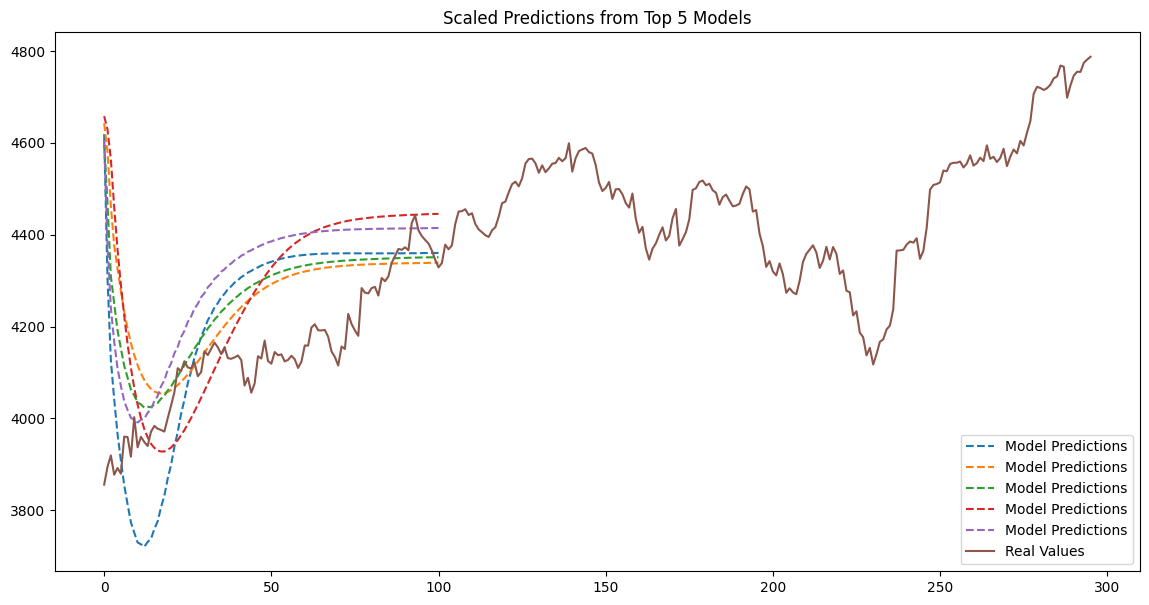

In [29]:
plt.figure(figsize=(14, 7))

for predictions in all_predictions:
    
    predictions_close = predictions[:, 0]
    predictions_close_inverse = sp500_scaler.inverse_transform(predictions_close)
    plt.plot(predictions_close_inverse[:, 0], label='Model Predictions', linestyle='--')

# Inverser la mise à l'échelle des valeurs réelles (y_test_final)
inverse_real_values = sp500_scaler.inverse_transform(y_test_final.reshape(-1, 1))

# Extraire les valeurs de clôture
inverse_real_values_close = inverse_real_values[:, 0]
plt.plot(inverse_real_values_close, label='Real Values')
plt.legend()

plt.title('Scaled Predictions from Top 5 Models')

plt.show()

#### Graphique comparatif avec les valeurs réelles

In [30]:
inverse_final_predictions = sp500_scaler.inverse_transform(median_predictions[:,0])
print(inverse_final_predictions.shape)

(101, 1)


In [31]:
# Afficher les dernières valeurs réelles pour chaque feature (y compris le SP500)
print("Dernières valeurs réelles :")
for feature in final_features:
    real_value = combined_data[feature].iloc[-1-len(y_test)]
    print(f"{feature}: {real_value}")

real_sp500 = combined_data[('GSPC', 'Close')].iloc[-1-len(y_test)]
print(f"GSPC_Close: {real_sp500}")

print("\nPremières valeurs prédites :")
# Afficher les premières valeurs prédites pour chaque feature
for feature in final_features:
    model_type = best_model_per_feature['Best Model'][feature]
    predicted_feature_value = all_recursive_preds[model_type][feature][0]
    # Inversez la mise à l'échelle pour la caractéristique prédite
    print(f"{feature}: {predicted_feature_value}")

# Afficher la première valeur prédite pour le SP500
predicted_sp500_value = median_predictions[0]
inverse_sp500_prediction = sp500_scaler.inverse_transform(np.array(predicted_sp500_value).reshape(-1, 1))
print(f"GSPC_Close : {inverse_sp500_prediction[0][0]}")

Dernières valeurs réelles :
('NG_F', 'Close'): 2.0969998836517334
('NVDA', 'Close'): 279.6499938964844
GSPC_Close: 4124.509765625

Premières valeurs prédites :
('NG_F', 'Close'): 8.780438423156738
('NVDA', 'Close'): 204.32029724121094
GSPC_Close : 4619.11572265625


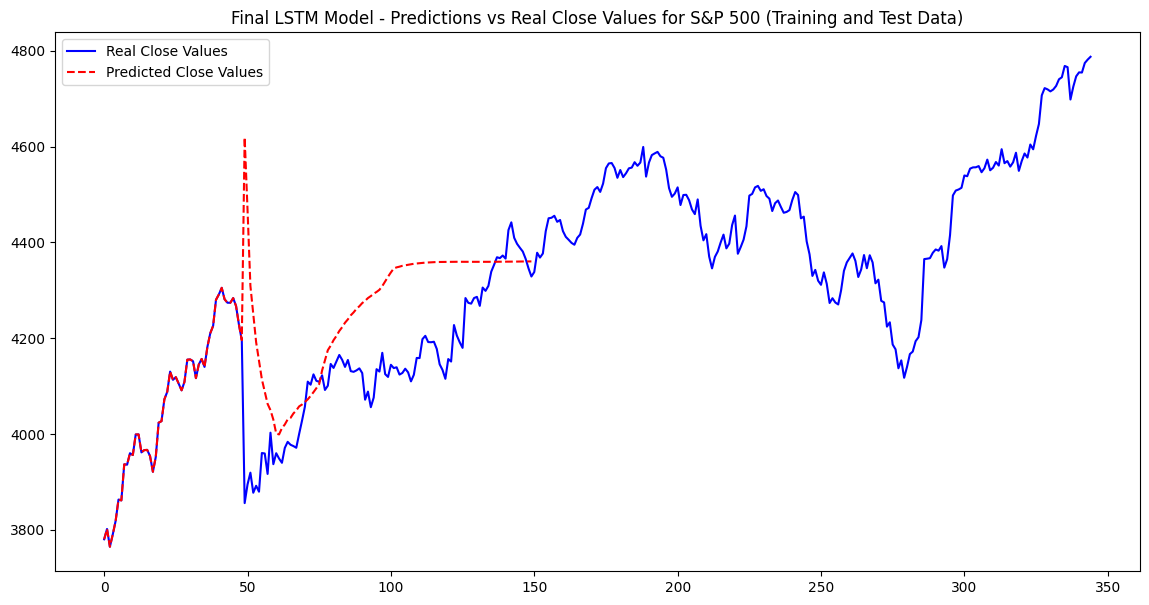

array([4195.873 , 4044.6523, 3886.1543, 3826.974 , 3768.3257, 3728.8994,
       3690.9937, 3665.7861, 3639.649 , 3626.6074, 3606.8223, 3577.7153,
       3575.8945, 3589.0874, 3596.602 , 3607.2695, 3610.351 , 3619.6787,
       3625.9326, 3634.421 , 3638.2705, 3643.499 , 3649.146 , 3656.2485,
       3664.0845, 3672.4019, 3681.1777, 3709.3164, 3730.771 , 3751.747 ,
       3761.2173, 3772.7383, 3781.4365, 3791.8564, 3799.7178, 3809.1274,
       3816.1187, 3824.5498, 3830.711 , 3838.142 , 3843.4858, 3850.0781,
       3854.7935, 3860.5957, 3864.7026, 3869.7544, 3873.338 , 3877.792 ,
       3885.6016, 3895.5771, 3905.1099, 3914.1636, 3922.4033, 3924.6504,
       3926.1074, 3927.879 , 3928.9858, 3930.3047, 3931.1196, 3932.165 ,
       3932.7988, 3933.5776, 3934.0283, 3934.5317, 3934.8882, 3935.2896,
       3935.5327, 3935.8208, 3935.9136, 3936.0464, 3936.0967, 3936.2163,
       3936.2983, 3936.3193, 3936.3018, 3936.2397, 3936.2158, 3936.1934,
       3936.2202, 3936.2124, 3936.1855, 3936.1528, 

In [32]:
inverse_final_predictions_close = inverse_final_predictions[:, 0]
# Utilisez le scaler pour inverser la mise à l'échelle des dernières valeurs réelles de l'ensemble d'entraînement pour le S&P 500
last_real_values_train_scaled = y_train_final
last_real_values_train = sp500_scaler.inverse_transform(last_real_values_train_scaled.reshape(-1, 1))[:, 0]  # On prend seulement les valeurs de clôture

# Inverser la mise à l'échelle des valeurs réelles (y_test_final)
inverse_real_values = sp500_scaler.inverse_transform(y_test_final.reshape(-1, 1))

# Extraire les valeurs de clôture
inverse_real_values_close = inverse_real_values[:, 0]

# Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les vraies valeurs de l'ensemble de test
real_values = np.concatenate([last_real_values_train, inverse_real_values_close])


#inverse_final_predictions_close = inverse_final_predictions_close -(inverse_final_predictions_close[0] - last_real_values_train[-1])

# Concaténer les dernières valeurs réelles de l'ensemble d'entraînement avec les valeurs prédites
predicted_values = np.concatenate([last_real_values_train, inverse_final_predictions_close])

inverse_final_predictions_close = inverse_final_predictions_close -(inverse_final_predictions_close[0] - last_real_values_train[-1])
plt.figure(figsize=(14,7))

# Tracer les valeurs réelles
plt.plot(real_values[-150 - (len(real_values) - len(predicted_values)):], label='Real Close Values', color='blue')
# Tracer les valeurs prédites
plt.plot(predicted_values[-150:], label='Predicted Close Values', color='red', linestyle='--')

plt.title("Final LSTM Model - Predictions vs Real Close Values for S&P 500 (Training and Test Data)")
plt.legend()
plt.show()

inverse_final_predictions_close

#### Prédiction futures:

1/1 [==============================] - 0s 90ms/step


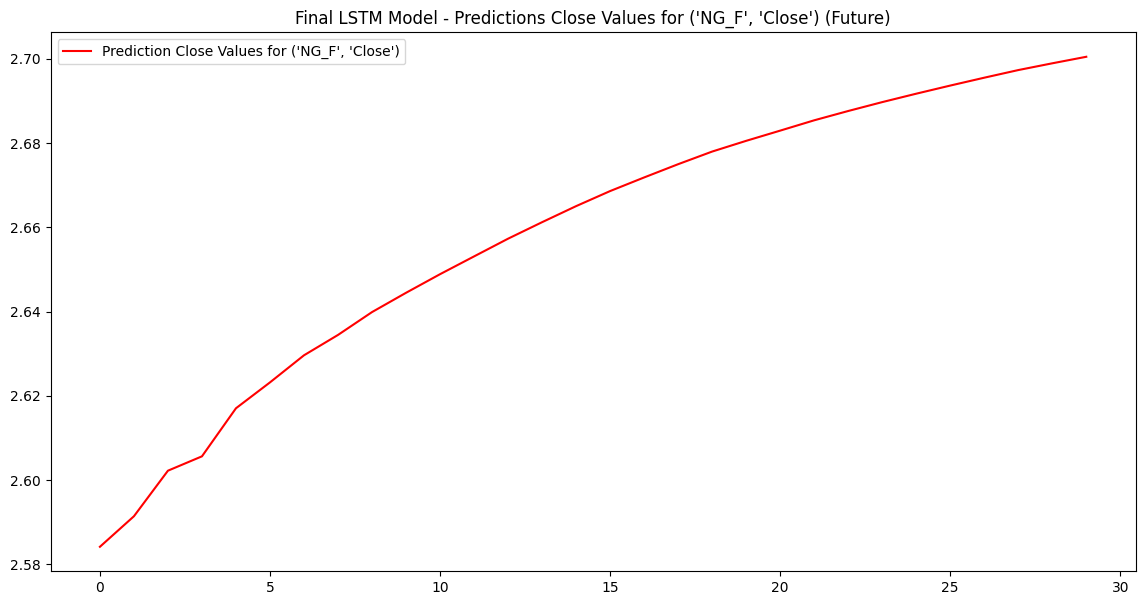

1/1 [==============================] - 0s 118ms/step


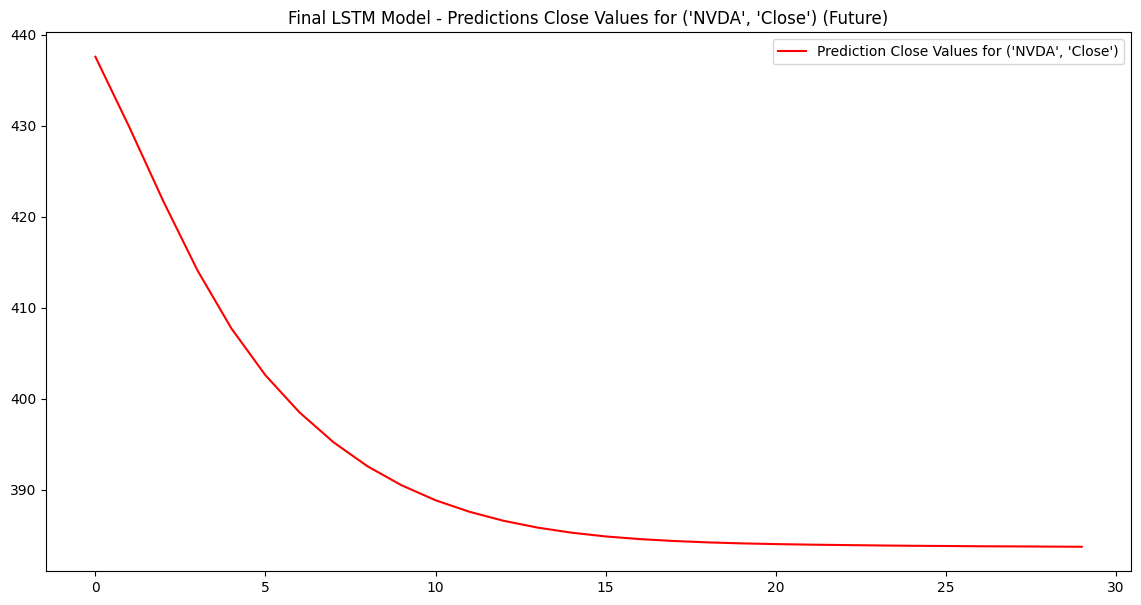

In [33]:
#other features
other_features_pred = []
for feature in final_features:
    model_type = best_model_per_feature['Best Model'][feature]
    if model_type == "GRU":
        model = gru_models[feature]
        initial_input = scaled_data_df[[feature]][-look_back:]
        predictions = recursive_prediction_multi_output(model, initial_input, 30)
        feature_scaler = scalers_dict[feature]
        predictions = feature_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        other_features_pred.append(predictions)
        
        plt.figure(figsize=(14,7))
        plt.plot(predictions, label=f'Prediction Close Values for {feature}', color='red')
        plt.title(f"Final LSTM Model - Predictions Close Values for {feature} (Future)")
        plt.legend()
        plt.show()

#### Métriques d'évaluation:

In [34]:
# Métriques d'évaluation
min_length = min(len(inverse_real_values_close), len(inverse_final_predictions_close))
mse = mean_squared_error(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])
rmse = np.sqrt(mse)
mae = mean_absolute_error(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])
r2 = r2_score(inverse_real_values_close[:min_length], inverse_final_predictions_close[:min_length])

print(f"Erreur quadratique moyenne MSE: {mse}")
print(f"Racine de l'erreur quadratique moyenne RMSE: {rmse}")
print(f"Erreur absolue moyenne MAE: {mae}")
print(f"Coefficient de détermination R²: {r2}")

Erreur quadratique moyenne MSE: 107333.13389021614
Racine de l'erreur quadratique moyenne RMSE: 327.6173589573912
Erreur absolue moyenne MAE: 312.7449233726839
Coefficient de détermination R²: -4.5338139707026635


In [35]:
# Calculer la direction réelle des changements de prix
real_direction = np.sign(np.diff(inverse_real_values_close[:min_length]))

# Calculer la direction prédite des changements de prix
predicted_direction = np.sign(np.diff(inverse_final_predictions_close[:min_length]))

# Créer une matrice de confusion
conf_matrix = confusion_matrix(real_direction, predicted_direction, labels=[1, -1])

print("Matrice de confusion:")
print(conf_matrix)

Matrice de confusion:
[[36 11]
 [41 12]]


# Simulation Gain/Perte

In [36]:
def simulate_trading_strategy(predictions, actual_prices, min_yield=0.000117, stop_loss=0.05, 
                              take_profit=0.05, transaction_fee=0.001, anticipation_days=2, delay_days=2):
    capital = 150
    realized_gain = [0]  # Gain that is realized by selling
    stock_quantity = 0  # Number of stocks owned
    capital_over_time = [capital]  # Track capital over time
    realized_gain_over_time = [realized_gain]  # Track realized gain over time

    last_price = actual_prices[0]

    for i in range(1, len(predictions)):

        if i % 5 != 0:
            continue

        start_window = max(0, i - anticipation_days)
        end_window = min(len(predictions) - 1, i + delay_days)
        
        window_predictions = predictions[start_window:end_window + 1]
        window_actuals = actual_prices[start_window:end_window + 1]
        
        mean_prediction = np.mean(window_predictions)
        mean_actual = np.mean(window_actuals)

        pred_today = mean_prediction
        pred_yesterday = predictions[i - 5]
        actual_today = mean_actual
        actual_yesterday = actual_prices[i - 5]
        
        expected_return = (pred_today - pred_yesterday) / pred_yesterday
        actual_return = (actual_today - actual_yesterday) / actual_yesterday

        if expected_return > min_yield and actual_return > min_yield:
            confidence_factor = 1.2
        else:
            confidence_factor = 1.0

        dynamic_stop_loss = stop_loss * confidence_factor
        dynamic_take_profit = take_profit * confidence_factor

        if stock_quantity > 0:
            gain_loss = (actual_today - last_price) / last_price

            if gain_loss >= dynamic_take_profit:
                capital += stock_quantity * actual_today * (1 - transaction_fee)
                realized_gain += stock_quantity * (actual_today - last_price)
                stock_quantity = 0

            elif gain_loss <= -dynamic_stop_loss:
                capital += stock_quantity * actual_today * (1 - transaction_fee)
                realized_gain += stock_quantity * (actual_today - last_price)
                stock_quantity = 0

        if expected_return > min_yield and capital > 0:
            buy_quantity = capital / actual_today
            capital -= buy_quantity * actual_today
            stock_quantity += buy_quantity
            last_price = actual_today

            print(f"Buy executed on day {i}. New stock quantity : {stock_quantity}")
            
        if expected_return < -min_yield and stock_quantity > 0:
            sell_quantity = stock_quantity  # sell all stocks
            capital += sell_quantity * actual_today  # Add to capital
            stock_quantity = 0  # Reset stock quantity
            last_price = actual_today  # Update the last price when a stock is sold
            print(f"Sell executed on day {i}. New stock quantity : 0")

        total_capital = capital + stock_quantity * actual_today
        capital_over_time.append(total_capital)
        realized_gain_over_time.append(realized_gain[0])

    strategy_returns = np.diff(np.array(capital_over_time)) / np.array(capital_over_time)[:-1]
    return strategy_returns, capital_over_time, realized_gain_over_time

strategy_returns, capital_over_time, realized_gain_over_time = simulate_trading_strategy(inverse_final_predictions_close, inverse_real_values)
realized_gain_over_time[0] = 0

Buy executed on day 20. New stock quantity : 0.037192199823406595


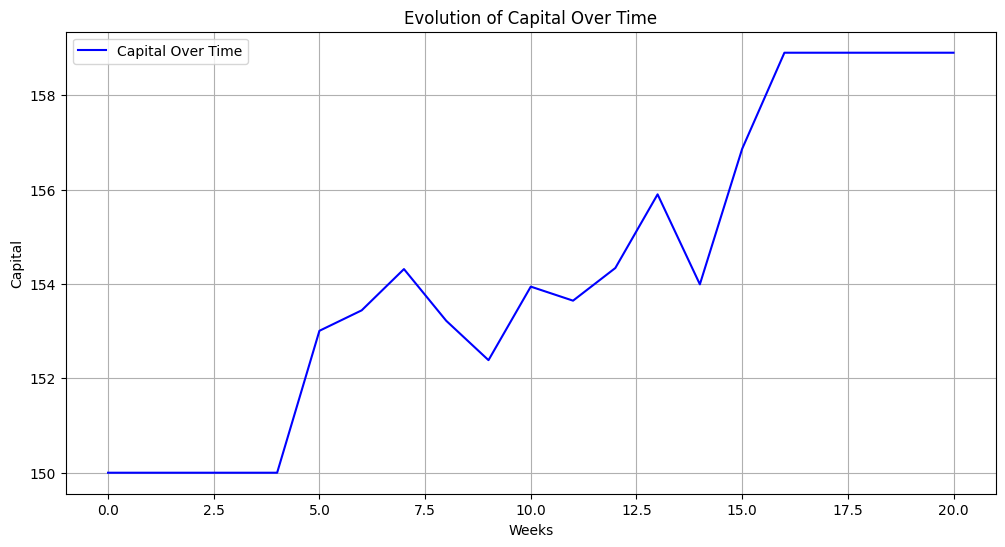

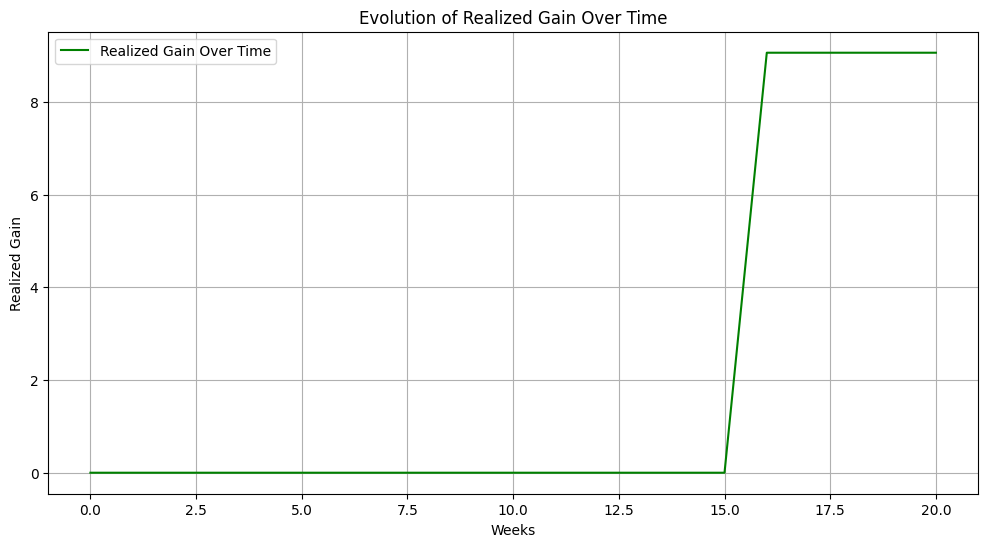

In [37]:
# Generate some sample data for the sake of demonstration
days = list(range(len(capital_over_time)))

# Plotting the evolution of capital over time
plt.figure(figsize=(12, 6))
plt.plot(days, capital_over_time, label="Capital Over Time", color='blue')
plt.xlabel("Weeks")
plt.ylabel("Capital")
plt.title("Evolution of Capital Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the evolution of realized gain over time
plt.figure(figsize=(12, 6))
plt.plot(days, realized_gain_over_time, label="Realized Gain Over Time", color='green')
plt.xlabel("Weeks")
plt.ylabel("Realized Gain")
plt.title("Evolution of Realized Gain Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# Calculate the absolute and percentage gain/loss

initial_capital = capital_over_time[0]

final_capital = capital_over_time[-1]



absolute_gain_loss = final_capital - initial_capital

percentage_gain_loss = ((final_capital - initial_capital) / initial_capital) * 100



# Calculate volatility as the standard deviation of the returns

returns = np.diff(np.array(capital_over_time)) / np.array(capital_over_time)[:-1]

volatility = np.std(returns)

print(f"Gain/perte absolu sur {len(capital_over_time)*5 -1} jours : {absolute_gain_loss}")
print(f"Gain/perte en % sur {len(capital_over_time)*5 -1} jours : {percentage_gain_loss}")
print(f"Volatilité de l'indice sur {len(capital_over_time)*5 -1} jours : {volatility}")

annualized_return_percentage = ((1 + percentage_gain_loss/100) ** (252 / len(capital_over_time)/5 -1) - 1) * 100

print(f"Taux gain/perte annualisé : {annualized_return_percentage}")

initial_market_price = inverse_real_values_close[0]
final_market_price = inverse_real_values_close[len(capital_over_time)*5 -1]
market_return = (final_market_price - initial_market_price) / initial_market_price * 100

# Calculate if we beat the market
beat_the_market = percentage_gain_loss > market_return

print(f"Rendement du marché en % sur {len(capital_over_time)*5 - 1} jours : {market_return}")
print(f"Est-ce que nous avons battu le marché ? {'Oui' if beat_the_market else 'Non'} : {market_return:.2f} % {'<' if beat_the_market else '>'} {percentage_gain_loss:.2f} %")

Gain/perte absolu sur 104 jours : 8.9018554417043
Gain/perte en % sur 104 jours : 5.934570294469533
Volatilité de l'indice sur 104 jours : 0.007904056867865404
Taux gain/perte annualisé : 8.405868459628628
Rendement du marché en % sur 104 jours : 13.514841488988324
Est-ce que nous avons battu le marché ? Non : 13.51 % > 5.93 %


In [39]:
# Calcul du ratio de Sharpe
mean_return = np.mean(np.diff(inverse_real_values_close) / inverse_real_values_close[:-1])
sharpe_ratio = mean_return / np.std(np.diff(inverse_real_values_close) / inverse_real_values_close[:-1])

print(f"Ratio de Sharpe: {sharpe_ratio}")

Ratio de Sharpe: 0.12017321831009918


## Conclusion

In [40]:
def calculate_directional_accuracy(real_values, predicted_values):
    correct_directions = 0
    total_directions = 0
    
    #fenêtre glissante sur 10 jours (2 semaines, du lundi au vendredi)
    for i in range(0, len(predicted_values), 5): #first cycle of 5 never used
        real_diff = real_values[i] - real_values[i-5]
        predicted_diff = predicted_values[i] - predicted_values[i-5]

        if (real_diff > 0 and predicted_diff > 0) or (real_diff < 0 and predicted_diff < 0):
            correct_directions += 1
        else: 
            print(f"Variation entre n°{i} et n°{i+5} fausse")

        total_directions += 1

    directional_accuracy = (correct_directions / total_directions) * 100
    return directional_accuracy

directional_accuracy = calculate_directional_accuracy(inverse_real_values_close, inverse_final_predictions_close)
print(f"Précision directionnelle sur 1 semaine: {directional_accuracy:.2f}%")

Variation entre n°0 et n°5 fausse
Variation entre n°5 et n°10 fausse
Variation entre n°10 et n°15 fausse
Variation entre n°35 et n°40 fausse
Variation entre n°40 et n°45 fausse
Variation entre n°45 et n°50 fausse
Variation entre n°70 et n°75 fausse
Variation entre n°80 et n°85 fausse
Variation entre n°100 et n°105 fausse
Précision directionnelle sur 1 semaine: 57.14%


Les résultats sont très encourageants, un investissement naïf au jour 0 aurait conduit à une perte de capital.

Les prédictions semblent très satisfaisantes dans la mesure où nous battons le marché sur cette période et ce, avec un taux de gain bien superieur au marché

Quelques points et améliorations cependant à soulever :

- Les prédictions des features autres que la valeur de l'indice lui-même ne sont disponibles que pour la valeur de clôture (et pas d'ouverture, pour l'ouverture on utilise donc la dernière valeur connue), la précision pour les modèles des features ainsi que le modèle final peut donc être encore augmenté.


- Toute la partie sur la simulation de gain/perte suppose que ce notebook n'est jamais réexécuté pendant 94 jours (valeur du look back), or, dans les faits, prédire à nouveau la valeur de l'indice avec les nouvelles valeurs réelles augmentera les chances de corriger les prédictions directionnelles fausses à plus long terme.


- Les performances passées ne préjugent pas des performances futures, c'est valable pour un fonds investi en actions tout comme les performances de ce notebook, prenez du recul sur les résultats produits par ce dernier s'il a une quelconque influence sur vos investissements.
